In [221]:
run_logdir

'/home/bhargav/Documents/MyNotebooks/my_logs/run_2020_11_28-11_04_49'

In [220]:
import os
root_logdir = os.path.join("/home/bhargav/Documents/MyNotebooks", "my_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()

In [1]:
import pandas as pd
usd_inr_data = pd.read_csv("/home/bhargav/Documents/PhD/Fall-2020/DataMining/Project/INR=X_Latest.csv")

In [2]:
usd_inr_data_na_removed = usd_inr_data.dropna()

In [3]:
def create_volatility_estimate_dataset(dataset, time_interval=25, volatility_measure="standard deviation") :
    import math
    if dataset.empty:
        return None
    #dataset.High  = column index = 2
    #dataset.Low   = column index = 3
    #dataset.Close = column index = 4
    #dataset.Open  = column index = 1
    hl = dataset.iloc[:,2]/dataset.iloc[:,3]
    co = dataset.iloc[:,4]/dataset.iloc[:,1]
    high_by_low = hl.apply(lambda x : math.log(math.pow(x,2)))
    close_by_open = co.apply(lambda x : math.log(math.pow(x,2)))
    
    if 'high_by_low' in dataset.columns:
        dataset = dataset.drop('high_by_low', axis=1)
    if 'close_by_open' in dataset.columns:
        dataset = dataset.drop('close_by_open', axis=1)
    
    dataset.insert(value = high_by_low,column='high_by_low', loc=7)
    dataset.insert(value = close_by_open,column='close_by_open', loc=8)
    
    if volatility_measure == "standard deviation" :
        standard_deviation_values = []
        for i in range(0,len(dataset.Price)-time_interval-1) :
            time_step_values=dataset.iloc[:,1].loc[i:(i+time_interval):,]
            standard_deviation_values.append(time_step_values.std())
        return standard_deviation_values
    elif volatility_measure == "parkinson volatility":
        parkinson_constant=1/(4*math.log(2))
        parkinson_volatility_values=[]
        for i in range(0,len(high_by_low)-time_interval-1) :
            time_step_values=high_by_low.loc[i:(i+time_interval):,]
            parkinson_volatility = parkinson_constant * time_step_values.mean()
            parkinson_volatility_values.append(parkinson_volatility)
        return parkinson_volatility_values
    elif volatility_measure == "garmin klass volatility" :
        gk_costant=(2*math.log(2)-1)
        factored_high_by_low = high_by_low.apply(lambda x : 0.5*x)
        close_by_open = dataset.close_by_open
        factored_close_by_open = close_by_open.apply(lambda x: gk_costant * x)
        diff_factored_values = factored_high_by_low - factored_close_by_open
        gk_volatility_values=[]
        for i in range(0,len(diff_factored_values)-time_interval-1) :
            gk_volatility_values.append(math.sqrt(diff_factored_values.loc[i:(i+time_interval):,].mean()))
        return gk_volatility_values
    else :
        return None

### 25 value time steps

In [4]:
data=create_volatility_estimate_dataset(usd_inr_data_na_removed, 
                                        time_interval=25, 
                                        volatility_measure='garmin klass volatility')

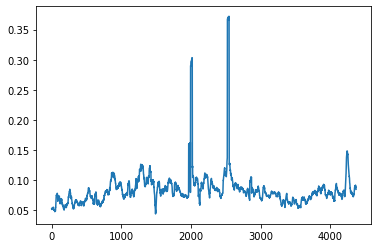

In [5]:
import matplotlib.pyplot as plt
plt.plot(data)

In [6]:
def split_train_test_data(dataset, train_size_percentage=65) :
    if len(dataset) == 0:
        return None
    train_set_size = int(len(dataset)*train_size_percentage/100)
    return dataset[0:train_set_size], dataset[train_set_size:len(dataset)]

In [7]:
train_data, test_data = split_train_test_data(data, train_size_percentage=80)

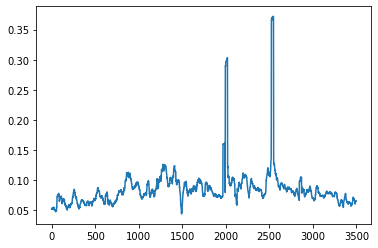

In [8]:
plt.plot(train_data)

In [9]:
def prepare_data(dataset, time_interval=25, return_3d=True):
    dataX, dataY = [], []
    for i in range(0, len(dataset)-time_interval-1) :
        dataX.append(dataset[i:i+time_interval])
        dataY.append(dataset[i+time_interval])
    dataX=np.array(dataX)
    dataY=np.array(dataY)
    if (return_3d == True):
      return dataX.reshape(dataX.shape[0], dataX.shape[1],1), dataY.reshape(dataY.shape[0], 1,1)
    else:
      return dataX, dataY

In [12]:
import numpy as np
train_data_X, train_data_Y = prepare_data(train_data, time_interval=25, return_3d=False)
test_data_X, test_data_Y = prepare_data(test_data, time_interval=25, return_3d=False)

In [13]:
from sklearn.linear_model import LinearRegression
linear_reg = LinearRegression()
linear_reg.fit(train_data_X, train_data_Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [14]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_true=test_data_Y, y_pred=linear_reg.predict(test_data_X))

1.6381391490308323e-06

In [15]:
mean_squared_error(y_true=train_data_Y, y_pred=linear_reg.predict(train_data_X))

5.907599233638974e-05

In [16]:
def predict_n_values(model, dataset, n_predict=25, time_steps=25, is_nn=True):
    predictX, predictY =[],[]
    dataset_copy = np.array(dataset)
    start_index=dataset_copy.shape[0]-time_steps
    for i in range(1,n_predict+1):
        print(start_index)
        predictX = dataset_copy[start_index:start_index+time_steps,]
        print("{} day input {}".format(i, predictX))
        if(is_nn) :
            next_predicted_value=model.predict(predictX.reshape(1, predictX.shape[0],1))
        else :
            next_predicted_value=model.predict(predictX.reshape(1,-1))
        print("day output : day_output_size {},  {}".format(next_predicted_value.shape, next_predicted_value))
        predictY.append(next_predicted_value)
        dataset_copy= np.append(dataset_copy,next_predicted_value)
        start_index= start_index+1
    return np.array(predictY)

In [17]:
predict_next_25_days = predict_n_values(model=linear_reg, dataset=data, is_nn=False)

4347
1 day input [0.08309061 0.08491355 0.08663897 0.08746788 0.08779821 0.08951975
 0.08972572 0.08992336 0.09059034 0.09022127 0.08909925 0.08984723
 0.09082845 0.09104664 0.09062027 0.09044403 0.09147885 0.09152353
 0.09108356 0.08882595 0.0876379  0.08887025 0.08796113 0.08593966
 0.08471678]
day output : day_output_size (1,),  [0.08484572]
4348
2 day input [0.08491355 0.08663897 0.08746788 0.08779821 0.08951975 0.08972572
 0.08992336 0.09059034 0.09022127 0.08909925 0.08984723 0.09082845
 0.09104664 0.09062027 0.09044403 0.09147885 0.09152353 0.09108356
 0.08882595 0.0876379  0.08887025 0.08796113 0.08593966 0.08471678
 0.08484572]
day output : day_output_size (1,),  [0.0848778]
4349
3 day input [0.08663897 0.08746788 0.08779821 0.08951975 0.08972572 0.08992336
 0.09059034 0.09022127 0.08909925 0.08984723 0.09082845 0.09104664
 0.09062027 0.09044403 0.09147885 0.09152353 0.09108356 0.08882595
 0.0876379  0.08887025 0.08796113 0.08593966 0.08471678 0.08484572
 0.0848778 ]
day outpu

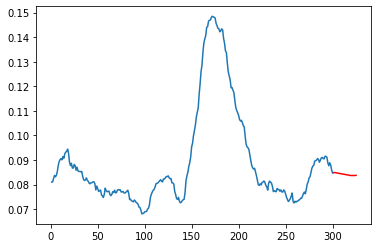

In [18]:
day_new=np.arange(1,301)
day_pred=np.arange(301,326)
plt.plot(day_new, np.array(data[len(data)-300:]).reshape(-1,1))
plt.plot(day_pred, predict_next_25_days, 'r')

#### LSTM

In [19]:
index = int(len(train_data)*0.15)
train_data=train_data[0:len(train_data)-index]
validation_data=train_data[len(train_data)-index:]
lstm_train_data_X, lstm_train_data_Y = prepare_data(train_data, time_interval=25)
lstm_test_data_X, lstm_test_data_Y = prepare_data(test_data, time_interval=25)
lstm_validation_data_X, lstm_validation_data_Y  = prepare_data(validation_data, time_interval=25)

In [20]:
print(lstm_train_data_X.shape)
print(lstm_train_data_Y.shape)

print(lstm_test_data_X.shape)
print(lstm_test_data_Y.shape)

print(lstm_validation_data_X.shape)
print(lstm_validation_data_Y.shape)

(2947, 25, 1)
(2947, 1, 1)
(849, 25, 1)
(849, 1, 1)
(498, 25, 1)
(498, 1, 1)


In [21]:
import tensorflow as tf
from tensorflow import keras

In [50]:
simple_lstm_model=keras.models.Sequential([
    keras.layers.LSTM(30, return_sequences=True, input_shape=[25,1]),
    keras.layers.LSTM(30),
    keras.layers.Dense(1)
])

In [51]:
simple_lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 25, 30)            3840      
_________________________________________________________________
lstm_8 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 31        
Total params: 11,191
Trainable params: 11,191
Non-trainable params: 0
_________________________________________________________________


In [59]:
learning_rate_scheduler = keras.optimizers.schedules.ExponentialDecay(0.001,
                                                                      decay_steps=10,
                                                                      decay_rate=0.96,
                                                                      staircase=True)
simple_lstm_model.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(learning_rate=learning_rate_scheduler))
early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
simple_lstm_model_history = simple_lstm_model.fit(x=lstm_train_data_X, 
                                                  y=lstm_train_data_Y, 
                                                  epochs=10000, 
                                                  validation_data=(lstm_validation_data_X, lstm_validation_data_Y),
                                                  callbacks=early_stopping)

Epoch 1/10000
93/93 [==============================] - 2s 27ms/step - loss: 9.0201e-05 - val_loss: 2.4313e-04
Epoch 2/10000
93/93 [==============================] - 2s 19ms/step - loss: 8.4372e-05 - val_loss: 2.4229e-04
Epoch 3/10000
93/93 [==============================] - 2s 19ms/step - loss: 7.7093e-05 - val_loss: 2.3153e-04
Epoch 4/10000
93/93 [==============================] - 2s 19ms/step - loss: 7.5594e-05 - val_loss: 2.2940e-04
Epoch 5/10000
93/93 [==============================] - 2s 19ms/step - loss: 7.4810e-05 - val_loss: 2.2799e-04
Epoch 6/10000
93/93 [==============================] - 2s 20ms/step - loss: 7.2523e-05 - val_loss: 2.3612e-04
Epoch 7/10000
93/93 [==============================] - 2s 20ms/step - loss: 7.2270e-05 - val_loss: 2.2659e-04
Epoch 8/10000
93/93 [==============================] - 2s 19ms/step - loss: 7.1150e-05 - val_loss: 2.2971e-04
Epoch 9/10000
93/93 [==============================] - 2s 19ms/step - loss: 7.0725e-05 - val_loss: 2.2540e-04
Epoch 10/1

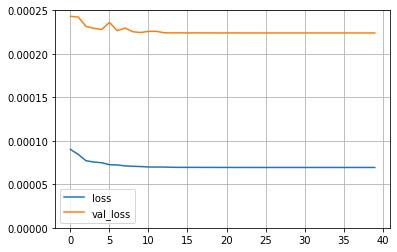

In [180]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(simple_lstm_model_history.history).plot()
plt.grid(True)
plt.gca().set_ylim(0,0.00025)
plt.show()

In [54]:
simple_lstm_model.predict(lstm_test_data_X).shape

(849, 1)

In [61]:
mean_squared_error(lstm_test_data_Y.reshape(lstm_test_data_Y.shape[0],1), 
                   simple_lstm_model.predict(lstm_test_data_X))

2.490044558059774e-06

In [62]:
mean_squared_error(lstm_train_data_Y.reshape(lstm_train_data_Y.shape[0],1), 
                   simple_lstm_model.predict(lstm_train_data_X))

6.937190504613128e-05

In [63]:
lstm_predict_next_25_days = predict_n_values(model=simple_lstm_model, dataset=data, is_nn=True)

4347
1 day input [0.08309061 0.08491355 0.08663897 0.08746788 0.08779821 0.08951975
 0.08972572 0.08992336 0.09059034 0.09022127 0.08909925 0.08984723
 0.09082845 0.09104664 0.09062027 0.09044403 0.09147885 0.09152353
 0.09108356 0.08882595 0.0876379  0.08887025 0.08796113 0.08593966
 0.08471678]
day output : day_output_size (1, 1),  [[0.0859789]]
4348
2 day input [0.08491355 0.08663897 0.08746788 0.08779821 0.08951975 0.08972572
 0.08992336 0.09059034 0.09022127 0.08909925 0.08984723 0.09082845
 0.09104664 0.09062027 0.09044403 0.09147885 0.09152353 0.09108356
 0.08882595 0.0876379  0.08887025 0.08796113 0.08593966 0.08471678
 0.0859789 ]
day output : day_output_size (1, 1),  [[0.0859503]]
4349
3 day input [0.08663897 0.08746788 0.08779821 0.08951975 0.08972572 0.08992336
 0.09059034 0.09022127 0.08909925 0.08984723 0.09082845 0.09104664
 0.09062027 0.09044403 0.09147885 0.09152353 0.09108356 0.08882595
 0.0876379  0.08887025 0.08796113 0.08593966 0.08471678 0.0859789
 0.0859503 ]
day

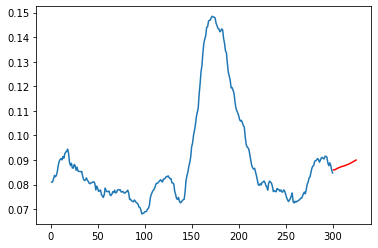

In [64]:
day_new=np.arange(1,301)
day_pred=np.arange(301,326)
plt.plot(day_new, np.array(data[len(data)-300:]).reshape(-1,1))
plt.plot(day_pred, lstm_predict_next_25_days.ravel(), 'r')

#### LSTM with Layer Normalization

In [34]:
layer_normalized_lstm_model_25=keras.models.Sequential([
    keras.layers.LSTM(30, return_sequences=True, input_shape=[25,1]),
    keras.layers.LayerNormalization(),
    keras.layers.LSTM(30),
    keras.layers.LayerNormalization(),
    keras.layers.Dense(1)
])

In [65]:
learning_rate_scheduler = keras.optimizers.schedules.ExponentialDecay(0.001,
                                                                      decay_steps=10,
                                                                      decay_rate=0.96,
                                                                      staircase=True)
layer_normalized_lstm_model_25.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(learning_rate=learning_rate_scheduler))
early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
layer_history = layer_normalized_lstm_model_25.fit(x=lstm_train_data_X, 
                                          y=lstm_train_data_Y, 
                                          epochs=1000, 
                                          validation_data=(lstm_validation_data_X, lstm_validation_data_Y),
                                          callbacks=early_stopping)

Epoch 1/1000
93/93 [==============================] - 3s 29ms/step - loss: 4.1275e-04 - val_loss: 2.1737e-04
Epoch 2/1000
93/93 [==============================] - 2s 21ms/step - loss: 7.0654e-05 - val_loss: 2.1257e-04
Epoch 3/1000
93/93 [==============================] - 2s 21ms/step - loss: 7.3131e-05 - val_loss: 2.1424e-04
Epoch 4/1000
93/93 [==============================] - 2s 21ms/step - loss: 7.1981e-05 - val_loss: 2.2803e-04
Epoch 5/1000
93/93 [==============================] - 2s 21ms/step - loss: 7.2043e-05 - val_loss: 2.1340e-04
Epoch 6/1000
93/93 [==============================] - 2s 21ms/step - loss: 7.0593e-05 - val_loss: 2.1334e-04
Epoch 7/1000
93/93 [==============================] - 2s 20ms/step - loss: 6.8220e-05 - val_loss: 2.1597e-04
Epoch 8/1000
93/93 [==============================] - 2s 20ms/step - loss: 6.9026e-05 - val_loss: 2.1409e-04
Epoch 9/1000
93/93 [==============================] - 2s 21ms/step - loss: 6.7818e-05 - val_loss: 2.1412e-04
Epoch 10/1000
93/93

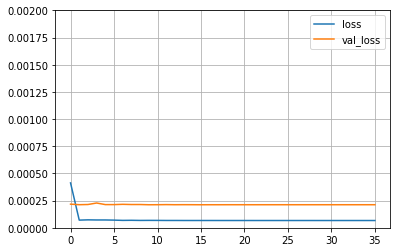

In [66]:
pd.DataFrame(layer_history.history).plot()
plt.grid(True)
plt.gca().set_ylim(0,0.002)
plt.show()

In [67]:
mean_squared_error(lstm_test_data_Y.reshape(lstm_test_data_Y.shape[0],1), 
                   layer_normalized_lstm_model_25.predict(lstm_test_data_X))

1.9606793398867603e-06

In [198]:
mean_squared_error(lstm_train_data_Y.reshape(lstm_train_data_Y.shape[0],1), 
                   layer_normalized_lstm_model_25.predict(lstm_train_data_X))

0.0006867324951095352

#### LSTM with Dropout

In [90]:
dropout_lstm_model_25=keras.models.Sequential([
    keras.layers.LSTM(30, return_sequences=True, input_shape=[25,1]),
    keras.layers.Dropout(0.1),
    keras.layers.LSTM(30),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1)
])

In [70]:
learning_rate_scheduler = keras.optimizers.schedules.ExponentialDecay(0.001,
                                                                      decay_steps=10,
                                                                      decay_rate=0.96,
                                                                      staircase=True)
dropout_lstm_model_25.compile(loss="mean_squared_error", 
                          optimizer=keras.optimizers.Adam(learning_rate=learning_rate_scheduler))
early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
dropout_lstm_model_25_history = dropout_lstm_model_25.fit(x=lstm_train_data_X, 
                                                          y=lstm_train_data_Y, 
                                                          epochs=1000, 
                                                          validation_data=(lstm_validation_data_X, 
                                                                           lstm_validation_data_Y),
                                                          callbacks=early_stopping)

Epoch 1/1000
93/93 [==============================] - 3s 30ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 2/1000
93/93 [==============================] - 2s 20ms/step - loss: 3.9000e-04 - val_loss: 0.0010
Epoch 3/1000
93/93 [==============================] - 2s 19ms/step - loss: 3.1868e-04 - val_loss: 9.0199e-04
Epoch 4/1000
93/93 [==============================] - 2s 19ms/step - loss: 2.9545e-04 - val_loss: 7.9903e-04
Epoch 5/1000
93/93 [==============================] - 2s 19ms/step - loss: 2.6788e-04 - val_loss: 7.2986e-04
Epoch 6/1000
93/93 [==============================] - 2s 20ms/step - loss: 2.4539e-04 - val_loss: 7.0214e-04
Epoch 7/1000
93/93 [==============================] - 2s 20ms/step - loss: 2.5022e-04 - val_loss: 7.0369e-04
Epoch 8/1000
93/93 [==============================] - 2s 20ms/step - loss: 2.3389e-04 - val_loss: 6.7579e-04
Epoch 9/1000
93/93 [==============================] - 2s 20ms/step - loss: 2.3702e-04 - val_loss: 6.8550e-04
Epoch 10/1000
93/93 [==========

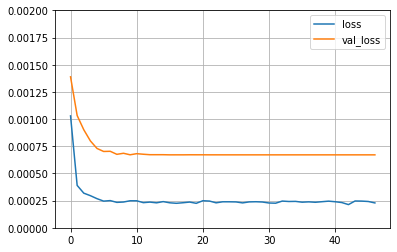

In [71]:
pd.DataFrame(dropout_lstm_model_25_history.history).plot()
plt.grid(True)
plt.gca().set_ylim(0,0.002)
plt.show()

In [72]:
mean_squared_error(lstm_test_data_Y.reshape(lstm_test_data_Y.shape[0],1), 
                   dropout_lstm_model_25.predict(lstm_test_data_X))

1.2700860585747924e-05

In [199]:
mean_squared_error(lstm_train_data_Y.reshape(lstm_train_data_Y.shape[0],1), 
                   dropout_lstm_model_25.predict(lstm_train_data_X))

0.006998458581652505

### 100 time step intervals

In [73]:
hundred_data=create_volatility_estimate_dataset(usd_inr_data_na_removed, 
                                        time_interval=100, 
                                        volatility_measure='garmin klass volatility')

In [74]:
hun_train_data, hun_test_data = split_train_test_data(hundred_data, train_size_percentage=80)

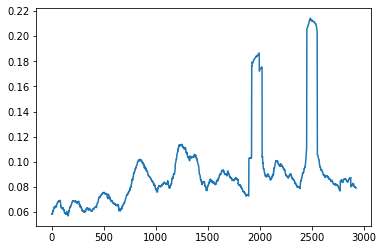

In [230]:
plt.plot(hun_train_data)

In [75]:
index = int(len(hun_train_data)*0.15)
hun_train_data=hun_train_data[0:len(hun_train_data)-index]
hun_validation_data=hun_train_data[len(hun_train_data)-index:]
hun_lstm_train_data_X, hun_lstm_train_data_Y = prepare_data(hun_train_data, time_interval=100)
hun_lstm_test_data_X, hun_lstm_test_data_Y = prepare_data(hun_test_data, time_interval=100)
hun_lstm_validation_data_X, hun_lstm_validation_data_Y  = prepare_data(hun_validation_data, time_interval=100)

In [76]:
print(hun_lstm_train_data_X.shape)
print(hun_lstm_train_data_Y.shape)

print(hun_lstm_test_data_X.shape)
print(hun_lstm_test_data_Y.shape)

print(hun_lstm_validation_data_X.shape)
print(hun_lstm_validation_data_Y.shape)

(2821, 100, 1)
(2821, 1, 1)
(759, 100, 1)
(759, 1, 1)
(414, 100, 1)
(414, 1, 1)


In [85]:
hun_simple_lstm_model=keras.models.Sequential([
    keras.layers.LSTM(30, return_sequences=True, input_shape=[100,1]),
    keras.layers.LSTM(30),
    keras.layers.Dense(1)
])

In [86]:
hun_simple_lstm_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 100, 30)           3840      
_________________________________________________________________
lstm_18 (LSTM)               (None, 30)                7320      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 31        
Total params: 11,191
Trainable params: 11,191
Non-trainable params: 0
_________________________________________________________________


In [87]:
learning_rate_scheduler = keras.optimizers.schedules.ExponentialDecay(0.001,
                                                                      decay_steps=10,
                                                                      decay_rate=0.96,
                                                                      staircase=True)
hun_simple_lstm_model.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(learning_rate=learning_rate_scheduler))
early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
hun_lstm_model_history = hun_simple_lstm_model.fit(x=hun_lstm_train_data_X, 
                                                  y=hun_lstm_train_data_Y, 
                                                  epochs=10000, 
                                                  validation_data=(hun_lstm_validation_data_X, hun_lstm_validation_data_Y),
                                                  callbacks=early_stopping)

Epoch 1/10000
89/89 [==============================] - 7s 75ms/step - loss: 5.5188e-04 - val_loss: 1.3991e-04
Epoch 2/10000
89/89 [==============================] - 6s 68ms/step - loss: 7.7760e-05 - val_loss: 1.2480e-04
Epoch 3/10000
89/89 [==============================] - 6s 65ms/step - loss: 7.1161e-05 - val_loss: 1.3863e-04
Epoch 4/10000
89/89 [==============================] - 7s 74ms/step - loss: 6.5181e-05 - val_loss: 1.2369e-04
Epoch 5/10000
89/89 [==============================] - 6s 73ms/step - loss: 6.2862e-05 - val_loss: 1.1405e-04
Epoch 6/10000
89/89 [==============================] - 6s 72ms/step - loss: 5.9596e-05 - val_loss: 1.0848e-04
Epoch 7/10000
89/89 [==============================] - 6s 66ms/step - loss: 5.7105e-05 - val_loss: 1.0709e-04
Epoch 8/10000
89/89 [==============================] - 6s 71ms/step - loss: 5.6041e-05 - val_loss: 1.0270e-04
Epoch 9/10000
89/89 [==============================] - 7s 81ms/step - loss: 5.5878e-05 - val_loss: 9.9423e-05
Epoch 10/1

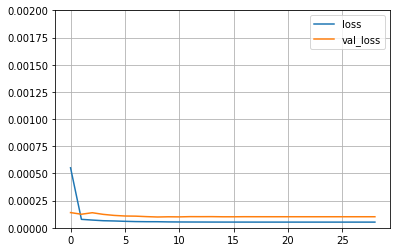

In [88]:
pd.DataFrame(hun_lstm_model_history.history).plot()
plt.grid(True)
plt.gca().set_ylim(0,0.002)
plt.show()

In [89]:
mean_squared_error(hun_lstm_test_data_Y.reshape(hun_lstm_test_data_Y.shape[0],1), 
                   hun_simple_lstm_model.predict(hun_lstm_test_data_X))

3.682259700318506e-06

In [200]:
mean_squared_error(hun_lstm_train_data_Y.reshape(hun_lstm_train_data_Y.shape[0],1), 
                   hun_simple_lstm_model.predict(hun_lstm_train_data_X))

5.560825827961035e-05

#### LSTM with Layer Normalizartion

In [91]:
hun_layer_normalized_lstm_model_100=keras.models.Sequential([
    keras.layers.LSTM(30, return_sequences=True, input_shape=[100,1]),
    keras.layers.LayerNormalization(),
    keras.layers.LSTM(30),
    keras.layers.LayerNormalization(),
    keras.layers.Dense(1)
])

In [92]:
learning_rate_scheduler = keras.optimizers.schedules.ExponentialDecay(0.001,
                                                                      decay_steps=10,
                                                                      decay_rate=0.96,
                                                                      staircase=True)
hun_layer_normalized_lstm_model_100.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(learning_rate=learning_rate_scheduler))
early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
hun_layer_normalized_lstm_model_100_history = hun_layer_normalized_lstm_model_100.fit(x=hun_lstm_train_data_X, 
                                                  y=hun_lstm_train_data_Y, 
                                                  epochs=10000, 
                                                  validation_data=(hun_lstm_validation_data_X, hun_lstm_validation_data_Y),
                                                  callbacks=early_stopping)

Epoch 1/10000
89/89 [==============================] - 7s 77ms/step - loss: 0.0649 - val_loss: 2.7192e-04
Epoch 2/10000
89/89 [==============================] - 7s 75ms/step - loss: 8.5238e-05 - val_loss: 1.1941e-04
Epoch 3/10000
89/89 [==============================] - 7s 84ms/step - loss: 6.6788e-05 - val_loss: 1.2055e-04
Epoch 4/10000
89/89 [==============================] - 7s 74ms/step - loss: 6.3254e-05 - val_loss: 1.0587e-04
Epoch 5/10000
89/89 [==============================] - 7s 77ms/step - loss: 6.1082e-05 - val_loss: 1.0495e-04
Epoch 6/10000
89/89 [==============================] - 7s 76ms/step - loss: 5.8349e-05 - val_loss: 1.0364e-04
Epoch 7/10000
89/89 [==============================] - 7s 79ms/step - loss: 5.6931e-05 - val_loss: 1.0097e-04
Epoch 8/10000
89/89 [==============================] - 8s 86ms/step - loss: 5.6030e-05 - val_loss: 1.0202e-04
Epoch 9/10000
89/89 [==============================] - 8s 91ms/step - loss: 5.4938e-05 - val_loss: 9.9694e-05
Epoch 10/10000

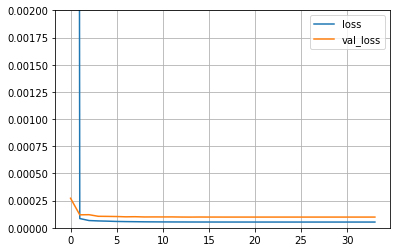

In [93]:
pd.DataFrame(hun_layer_normalized_lstm_model_100_history.history).plot()
plt.grid(True)
plt.gca().set_ylim(0,0.002)
plt.show()

In [94]:
mean_squared_error(hun_lstm_test_data_Y.reshape(hun_lstm_test_data_Y.shape[0],1), 
                   hun_layer_normalized_lstm_model_100.predict(hun_lstm_test_data_X))

8.997632154254174e-06

In [201]:
mean_squared_error(hun_lstm_train_data_Y.reshape(hun_lstm_train_data_Y.shape[0],1), 
                   hun_layer_normalized_lstm_model_100.predict(hun_lstm_train_data_X))

5.331742506166014e-05

#### LSTM with Dropout

In [95]:
dropout_lstm_model_100=keras.models.Sequential([
    keras.layers.LSTM(30, return_sequences=True, input_shape=[100,1]),
    keras.layers.Dropout(0.1),
    keras.layers.LSTM(30),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1)
])

In [96]:
learning_rate_scheduler = keras.optimizers.schedules.ExponentialDecay(0.001,
                                                                      decay_steps=10,
                                                                      decay_rate=0.96,
                                                                      staircase=True)
dropout_lstm_model_100.compile(loss="mean_squared_error", 
                               optimizer=keras.optimizers.Adam(learning_rate=learning_rate_scheduler))
early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
dropout_lstm_model_100_history = dropout_lstm_model_100.fit(x=hun_lstm_train_data_X, 
                                                  y=hun_lstm_train_data_Y, 
                                                  epochs=10000, 
                                                  validation_data=(hun_lstm_validation_data_X, 
                                                                   hun_lstm_validation_data_Y),
                                                  callbacks=early_stopping)

Epoch 1/10000
89/89 [==============================] - 7s 82ms/step - loss: 7.8811e-04 - val_loss: 1.2929e-04
Epoch 2/10000
89/89 [==============================] - 7s 79ms/step - loss: 1.2604e-04 - val_loss: 1.2326e-04
Epoch 3/10000
89/89 [==============================] - 6s 72ms/step - loss: 1.1486e-04 - val_loss: 1.3102e-04
Epoch 4/10000
89/89 [==============================] - 6s 66ms/step - loss: 1.1269e-04 - val_loss: 1.1775e-04
Epoch 5/10000
89/89 [==============================] - 6s 67ms/step - loss: 1.0526e-04 - val_loss: 1.1485e-04
Epoch 6/10000
89/89 [==============================] - 6s 71ms/step - loss: 1.0150e-04 - val_loss: 1.1512e-04
Epoch 7/10000
89/89 [==============================] - 7s 73ms/step - loss: 9.9260e-05 - val_loss: 1.2050e-04
Epoch 8/10000
89/89 [==============================] - 7s 74ms/step - loss: 1.0018e-04 - val_loss: 1.0938e-04
Epoch 9/10000
89/89 [==============================] - 6s 69ms/step - loss: 9.2184e-05 - val_loss: 1.1058e-04
Epoch 10/1

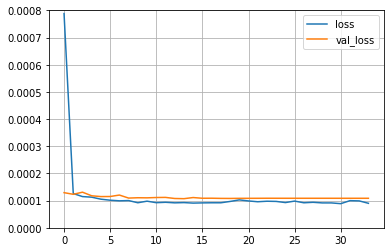

In [99]:
pd.DataFrame(dropout_lstm_model_100_history.history).plot()
plt.grid(True)
plt.gca().set_ylim(0,0.0008)
plt.show()

In [100]:
mean_squared_error(hun_lstm_test_data_Y.reshape(hun_lstm_test_data_Y.shape[0],1), 
                   dropout_lstm_model_100.predict(hun_lstm_test_data_X))

3.711810432254315e-06

In [203]:
mean_squared_error(hun_lstm_train_data_Y.reshape(hun_lstm_train_data_Y.shape[0],1), 
                   dropout_lstm_model_100.predict(hun_lstm_train_data_X))

5.8627521784724904e-05

### 150 time step values

In [101]:
one_fifty_data=create_volatility_estimate_dataset(usd_inr_data_na_removed, 
                                        time_interval=150, 
                                        volatility_measure='garmin klass volatility')

In [102]:
one_fifty_train_data, one_fifty_test_data = split_train_test_data(one_fifty_data, train_size_percentage=80)

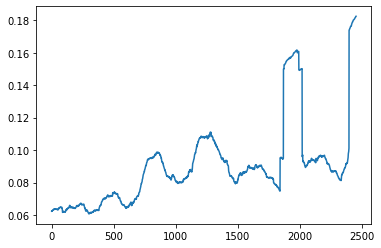

In [231]:
plt.plot(one_fifty_train_data)

In [126]:
index = int(len(one_fifty_train_data)*0.15)
one_fifty_train_data=one_fifty_train_data[0:len(one_fifty_train_data)-index]
one_fifty_validation_data=one_fifty_train_data[len(one_fifty_train_data)-index:]

one_fifty_lstm_train_data_X, one_fifty_lstm_train_data_Y = prepare_data(one_fifty_train_data, 
                                                                        time_interval=150)
one_fifty_lstm_test_data_X, one_fifty_lstm_test_data_Y = prepare_data(one_fifty_test_data, 
                                                                      time_interval=150)
one_fifty_lstm_validation_data_X, one_fifty_lstm_validation_data_Y = prepare_data(one_fifty_validation_data, 
                                                                                  time_interval=150)

In [127]:
print(one_fifty_lstm_train_data_X.shape)
print(one_fifty_lstm_train_data_Y.shape)

print(one_fifty_lstm_test_data_X.shape)
print(one_fifty_lstm_test_data_Y.shape)

print(one_fifty_lstm_validation_data_X.shape)
print(one_fifty_lstm_validation_data_Y.shape)

(2304, 150, 1)
(2304, 1, 1)
(699, 150, 1)
(699, 1, 1)
(282, 150, 1)
(282, 1, 1)


In [128]:
one_fifty_lstm_model=keras.models.Sequential([
    keras.layers.LSTM(30, return_sequences=True, input_shape=[150,1]),
    keras.layers.LSTM(30),
    keras.layers.Dense(1)
])

In [129]:
learning_rate_scheduler = keras.optimizers.schedules.ExponentialDecay(0.001,
                                                                      decay_steps=10,
                                                                      decay_rate=0.96,
                                                                      staircase=True)
one_fifty_lstm_model.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(learning_rate=learning_rate_scheduler))
early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
one_fifty_lstm_model_history = one_fifty_lstm_model.fit(x=one_fifty_lstm_train_data_X, 
                                                  y=one_fifty_lstm_train_data_Y, 
                                                  epochs=10000, 
                                                  validation_data=(one_fifty_lstm_validation_data_X, 
                                                                   one_fifty_lstm_validation_data_Y),
                                                  callbacks=early_stopping)

Epoch 1/10000
72/72 [==============================] - 7s 97ms/step - loss: 7.8921e-04 - val_loss: 3.7636e-04
Epoch 2/10000
72/72 [==============================] - 6s 80ms/step - loss: 5.6795e-05 - val_loss: 1.4388e-04
Epoch 3/10000
72/72 [==============================] - 5s 70ms/step - loss: 3.9343e-05 - val_loss: 1.3777e-04
Epoch 4/10000
72/72 [==============================] - 5s 68ms/step - loss: 3.6697e-05 - val_loss: 1.3622e-04
Epoch 5/10000
72/72 [==============================] - 5s 68ms/step - loss: 3.5751e-05 - val_loss: 1.2400e-04
Epoch 6/10000
72/72 [==============================] - 5s 67ms/step - loss: 3.4458e-05 - val_loss: 1.2532e-04
Epoch 7/10000
72/72 [==============================] - 5s 66ms/step - loss: 3.3585e-05 - val_loss: 1.2237e-04
Epoch 8/10000
72/72 [==============================] - 5s 70ms/step - loss: 3.3128e-05 - val_loss: 1.1879e-04
Epoch 9/10000
72/72 [==============================] - 5s 69ms/step - loss: 3.2484e-05 - val_loss: 1.1798e-04
Epoch 10/1

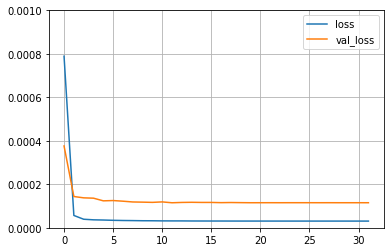

In [131]:
pd.DataFrame(one_fifty_lstm_model_history.history).plot()
plt.grid(True)
plt.gca().set_ylim(0,0.001)
plt.show()

In [132]:
mean_squared_error(one_fifty_lstm_test_data_Y.reshape(one_fifty_lstm_test_data_Y.shape[0],1), 
                   one_fifty_lstm_model.predict(one_fifty_lstm_test_data_X))

1.5775940030881233e-06

In [204]:
mean_squared_error(one_fifty_lstm_train_data_Y.reshape(one_fifty_lstm_train_data_Y.shape[0],1), 
                   one_fifty_lstm_model.predict(one_fifty_lstm_train_data_X))

5.192194999735348e-06

#### LSTM with Layer Normalization

In [133]:
onefifty_layer_lstm_model=keras.models.Sequential([
    keras.layers.LSTM(30, return_sequences=True, input_shape=[150,1]),
    keras.layers.LayerNormalization(),
    keras.layers.LSTM(30),
    keras.layers.LayerNormalization(),
    keras.layers.Dense(1)
])

In [134]:
learning_rate_scheduler = keras.optimizers.schedules.ExponentialDecay(0.001,
                                                                      decay_steps=10,
                                                                      decay_rate=0.96,
                                                                      staircase=True)
onefifty_layer_lstm_model.compile(loss="mean_squared_error", 
                                  optimizer=keras.optimizers.Adam(learning_rate=learning_rate_scheduler))
early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
one_fifty_lstm_model_history = onefifty_layer_lstm_model.fit(x=one_fifty_lstm_train_data_X, 
                                                             y=one_fifty_lstm_train_data_Y, 
                                                             epochs=10000, 
                                                             validation_data=(one_fifty_lstm_validation_data_X, 
                                                             one_fifty_lstm_validation_data_Y),
                                                             callbacks=early_stopping)

Epoch 1/10000
72/72 [==============================] - 6s 81ms/step - loss: 0.1311 - val_loss: 0.0022
Epoch 2/10000
72/72 [==============================] - 5s 71ms/step - loss: 5.7275e-04 - val_loss: 7.8515e-04
Epoch 3/10000
72/72 [==============================] - 5s 71ms/step - loss: 1.6990e-04 - val_loss: 4.4561e-04
Epoch 4/10000
72/72 [==============================] - 5s 71ms/step - loss: 1.0521e-04 - val_loss: 3.2727e-04
Epoch 5/10000
72/72 [==============================] - 5s 73ms/step - loss: 9.2359e-05 - val_loss: 2.8182e-04
Epoch 6/10000
72/72 [==============================] - 5s 74ms/step - loss: 8.8505e-05 - val_loss: 2.6137e-04
Epoch 7/10000
72/72 [==============================] - 5s 72ms/step - loss: 8.5614e-05 - val_loss: 2.5282e-04
Epoch 8/10000
72/72 [==============================] - 5s 72ms/step - loss: 8.3843e-05 - val_loss: 2.4900e-04
Epoch 9/10000
72/72 [==============================] - 5s 74ms/step - loss: 8.2597e-05 - val_loss: 2.4174e-04
Epoch 10/10000
72/

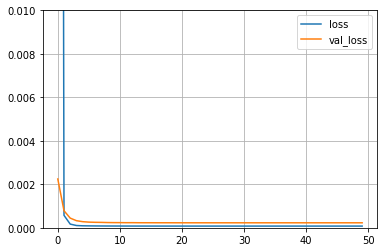

In [135]:
pd.DataFrame(one_fifty_lstm_model_history.history).plot()
plt.grid(True)
plt.gca().set_ylim(0,0.01)
plt.show()

In [136]:
mean_squared_error(one_fifty_lstm_test_data_Y.reshape(one_fifty_lstm_test_data_Y.shape[0],1), 
                   onefifty_layer_lstm_model.predict(one_fifty_lstm_test_data_X))

1.713049637441839e-05

In [206]:
mean_squared_error(one_fifty_lstm_train_data_Y.reshape(one_fifty_lstm_train_data_Y.shape[0],1), 
                   onefifty_layer_lstm_model.predict(one_fifty_lstm_train_data_X))

3.7878427335702705e-05

#### LSTM with Dropout

In [137]:
onefifty_dropout_lstm_model=keras.models.Sequential([
    keras.layers.LSTM(30, return_sequences=True, input_shape=[150,1]),
    keras.layers.Dropout(0.1),
    keras.layers.LSTM(30),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1)
])

In [138]:
learning_rate_scheduler = keras.optimizers.schedules.ExponentialDecay(0.001,
                                                                      decay_steps=10,
                                                                      decay_rate=0.96,
                                                                      staircase=True)
onefifty_layer_lstm_model.compile(loss="mean_squared_error", 
                                  optimizer=keras.optimizers.Adam(learning_rate=learning_rate_scheduler))
early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
one_fifty_lstm_model_history = onefifty_layer_lstm_model.fit(x=one_fifty_lstm_train_data_X, 
                                                             y=one_fifty_lstm_train_data_Y, 
                                                             epochs=10000, 
                                                             validation_data=(one_fifty_lstm_validation_data_X, 
                                                             one_fifty_lstm_validation_data_Y),
                                                             callbacks=early_stopping)

Epoch 1/10000
72/72 [==============================] - 6s 82ms/step - loss: 0.0152 - val_loss: 4.9349e-04
Epoch 2/10000
72/72 [==============================] - 5s 71ms/step - loss: 6.9913e-05 - val_loss: 1.7531e-04
Epoch 3/10000
72/72 [==============================] - 5s 72ms/step - loss: 5.8442e-05 - val_loss: 1.5497e-04
Epoch 4/10000
72/72 [==============================] - 5s 72ms/step - loss: 5.1422e-05 - val_loss: 1.5045e-04
Epoch 5/10000
72/72 [==============================] - 5s 76ms/step - loss: 4.9497e-05 - val_loss: 1.4091e-04
Epoch 6/10000
72/72 [==============================] - 5s 72ms/step - loss: 4.6650e-05 - val_loss: 1.3898e-04
Epoch 7/10000
72/72 [==============================] - 5s 74ms/step - loss: 4.4743e-05 - val_loss: 1.3500e-04
Epoch 8/10000
72/72 [==============================] - 6s 77ms/step - loss: 4.2922e-05 - val_loss: 1.2747e-04
Epoch 9/10000
72/72 [==============================] - 5s 76ms/step - loss: 4.1715e-05 - val_loss: 1.2654e-04
Epoch 10/10000

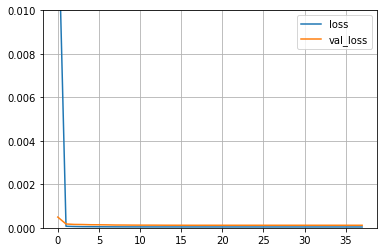

In [139]:
pd.DataFrame(one_fifty_lstm_model_history.history).plot()
plt.grid(True)
plt.gca().set_ylim(0,0.01)
plt.show()

In [140]:
mean_squared_error(one_fifty_lstm_test_data_Y.reshape(one_fifty_lstm_test_data_Y.shape[0],1), 
                   onefifty_layer_lstm_model.predict(one_fifty_lstm_test_data_X))

7.934447502179693e-06

In [205]:
mean_squared_error(one_fifty_lstm_train_data_Y.reshape(one_fifty_lstm_train_data_Y.shape[0],1), 
                   onefifty_layer_lstm_model.predict(one_fifty_lstm_train_data_X))

3.7878427335702705e-05

### Drop out with Layer Normalization

In [158]:
onefifty_layer_dropout_lstm_model=keras.models.Sequential([
    keras.layers.LSTM(30, return_sequences=True, input_shape=[150,1]),
    keras.layers.LayerNormalization(),
    keras.layers.Dropout(0.1),
    keras.layers.LSTM(30),
    keras.layers.LayerNormalization(),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1)
])

In [160]:
learning_rate_scheduler = keras.optimizers.schedules.ExponentialDecay(0.001,
                                                                      decay_steps=10,
                                                                      decay_rate=0.96,
                                                                      staircase=True)
onefifty_layer_dropout_lstm_model.compile(loss="mean_squared_error", 
                                  optimizer=keras.optimizers.Adam(learning_rate=learning_rate_scheduler))
early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
one_fifty_lstm_model_history = onefifty_layer_dropout_lstm_model.fit(x=one_fifty_lstm_train_data_X, 
                                                             y=one_fifty_lstm_train_data_Y, 
                                                             epochs=10000, 
                                                             validation_data=(one_fifty_lstm_validation_data_X, 
                                                             one_fifty_lstm_validation_data_Y),
                                                             callbacks=early_stopping)

Epoch 1/10000
72/72 [==============================] - 6s 84ms/step - loss: 0.1973 - val_loss: 0.0026
Epoch 2/10000
72/72 [==============================] - 5s 74ms/step - loss: 0.0663 - val_loss: 0.0024
Epoch 3/10000
72/72 [==============================] - 5s 74ms/step - loss: 0.0447 - val_loss: 0.0011
Epoch 4/10000
72/72 [==============================] - 6s 89ms/step - loss: 0.0326 - val_loss: 9.7057e-04
Epoch 5/10000
72/72 [==============================] - 6s 81ms/step - loss: 0.0235 - val_loss: 8.6646e-04
Epoch 6/10000
72/72 [==============================] - 6s 80ms/step - loss: 0.0188 - val_loss: 4.1763e-04
Epoch 7/10000
72/72 [==============================] - 7s 100ms/step - loss: 0.0158 - val_loss: 5.4841e-04
Epoch 8/10000
72/72 [==============================] - 6s 76ms/step - loss: 0.0142 - val_loss: 4.9791e-04
Epoch 9/10000
72/72 [==============================] - 5s 75ms/step - loss: 0.0117 - val_loss: 4.3911e-04
Epoch 10/10000
72/72 [==============================] - 5

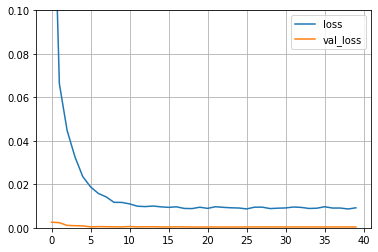

In [162]:
pd.DataFrame(one_fifty_lstm_model_history.history).plot()
plt.grid(True)
plt.gca().set_ylim(0,0.1)
plt.show()

In [163]:
mean_squared_error(one_fifty_lstm_test_data_Y.reshape(one_fifty_lstm_test_data_Y.shape[0],1), 
                   onefifty_layer_dropout_lstm_model.predict(one_fifty_lstm_test_data_X))

2.0244033218300108e-05

### 200 step intervals

In [141]:
two_data=create_volatility_estimate_dataset(usd_inr_data_na_removed, 
                                        time_interval=200, 
                                        volatility_measure='garmin klass volatility')

In [142]:
two_train_data, two_test_data = split_train_test_data(two_data, train_size_percentage=80)

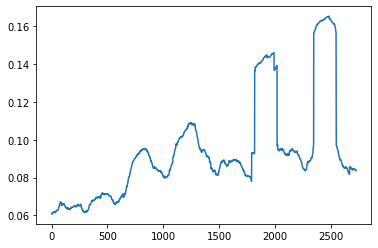

In [234]:
plt.plot(two_train_data)

In [143]:
index = int(len(two_data)*0.15)
two_train_data=two_train_data[0:len(two_train_data)-index]
two_validation_data=two_train_data[len(two_train_data)-index:]

two_lstm_train_data_X, two_lstm_train_data_Y = prepare_data(two_train_data, 
                                                            time_interval=200)
two_lstm_test_data_X, two_lstm_test_data_Y = prepare_data(two_test_data, 
                                                          time_interval=200)
two_lstm_validation_data_X, two_lstm_validation_data_Y = prepare_data(two_validation_data, 
                                                                      time_interval=200)

In [145]:
print(two_lstm_train_data_X.shape)
print(two_lstm_train_data_Y.shape)

print(two_lstm_test_data_X.shape)
print(two_lstm_test_data_Y.shape)

print(two_lstm_validation_data_X.shape)
print(two_lstm_validation_data_Y.shape)

(2527, 200, 1)
(2527, 1, 1)
(639, 200, 1)
(639, 1, 1)
(428, 200, 1)
(428, 1, 1)


#### LSTM 

In [146]:
two_hun_lstm_model=keras.models.Sequential([
    keras.layers.LSTM(30, return_sequences=True, input_shape=[200,1]),
    keras.layers.LSTM(30),
    keras.layers.Dense(1)
])

In [222]:
learning_rate_scheduler = keras.optimizers.schedules.ExponentialDecay(0.001,
                                                                      decay_steps=10,
                                                                      decay_rate=0.96,
                                                                      staircase=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
two_hun_lstm_model.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(learning_rate=learning_rate_scheduler))
early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
two_hun_lstm_model_history = two_hun_lstm_model.fit(x=two_lstm_train_data_X, 
                                                  y=two_lstm_train_data_Y, 
                                                  epochs=10000, 
                                                  validation_data=(two_lstm_validation_data_X, 
                                                                   two_lstm_validation_data_Y),
                                                  callbacks=[early_stopping,tensorboard_cb])

Epoch 1/10000
 1/79 [..............................] - ETA: 0s - loss: 1.0204e-07WARNING:tensorflow:From /home/bhargav/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
79/79 [==============================] - 15s 196ms/step - loss: 7.8034e-06 - val_loss: 1.6553e-05
Epoch 2/10000
79/79 [==============================] - 10s 125ms/step - loss: 5.1647e-06 - val_loss: 1.6343e-05
Epoch 3/10000
79/79 [==============================] - 11s 139ms/step - loss: 4.6267e-06 - val_loss: 1.6291e-05
Epoch 4/10000
79/79 [==============================] - 13s 160ms/step - loss: 4.5491e-06 - val_loss: 1.6353e-05
Epoch 5/10000
79/79 [==============================] - 11s 143ms/step - loss: 4.6862e-06 - val_loss: 1.8352e-05
Epoch 6/10000
79/79 [==============================] - 11s 135ms/step - loss: 4.57

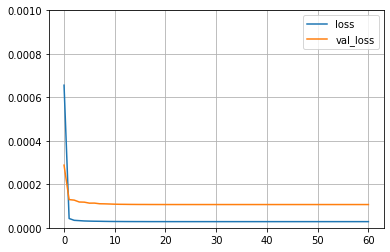

In [149]:
pd.DataFrame(two_hun_lstm_model_history.history).plot()
plt.grid(True)
plt.gca().set_ylim(0,0.001)
plt.show()

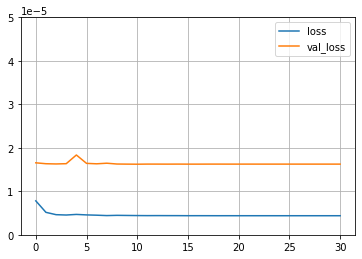

In [236]:
## Run with tensor board
pd.DataFrame(two_hun_lstm_model_history.history).plot()
plt.grid(True)
plt.gca().set_ylim(0,0.00005)
plt.show()

In [150]:
mean_squared_error(two_lstm_test_data_Y.reshape(two_lstm_test_data_Y.shape[0],1), 
                   two_hun_lstm_model.predict(two_lstm_test_data_X))

1.0354816609293705e-06

In [224]:
## Run with tensor board
mean_squared_error(two_lstm_test_data_Y.reshape(two_lstm_test_data_Y.shape[0],1), 
                   two_hun_lstm_model.predict(two_lstm_test_data_X))

5.648425111471798e-08

In [208]:
mean_squared_error(two_lstm_train_data_Y.reshape(two_lstm_train_data_Y.shape[0],1), 
                   two_hun_lstm_model.predict(two_lstm_train_data_X))

4.45052759238478e-06

In [225]:
## Run with tensor board
mean_squared_error(two_lstm_train_data_Y.reshape(two_lstm_train_data_Y.shape[0],1), 
                   two_hun_lstm_model.predict(two_lstm_train_data_X))

4.398330021635324e-06

#### Predict the next 25 values

In [228]:
lstm_predict_next_25_days = predict_n_values(model=two_hun_lstm_model, dataset=data, n_predict=100, time_steps=200, is_nn=True)

4172
1 day input [0.0689518  0.0690316  0.06996761 0.07034709 0.07146281 0.07455489
 0.07592832 0.07683944 0.07763279 0.07795241 0.07891073 0.08024733
 0.0805149  0.08060887 0.08110208 0.08153648 0.08195992 0.08132509
 0.0810559  0.08226015 0.08222418 0.08267693 0.08326154 0.08318343
 0.08353413 0.08281488 0.08241343 0.08245315 0.08073003 0.08063267
 0.08020341 0.07715438 0.07589793 0.07421787 0.07399432 0.07475202
 0.07318801 0.07255311 0.07282358 0.07342898 0.07380676 0.07395209
 0.07680022 0.0815504  0.0835559  0.08505027 0.08737173 0.0888978
 0.09125539 0.09537066 0.09687256 0.10000165 0.10199506 0.10424233
 0.10747678 0.10943354 0.11112731 0.11683252 0.12092045 0.12595704
 0.12856075 0.13375613 0.13758277 0.13928389 0.14063098 0.14402744
 0.14428478 0.14654419 0.1469124  0.1469988  0.14808648 0.14853283
 0.1482013  0.14817508 0.14781977 0.14569137 0.14473563 0.14360667
 0.14343338 0.14218779 0.1425731  0.14338573 0.14299583 0.1395038
 0.13756834 0.13446104 0.13373772 0.12948954 0.

day output : day_output_size (1, 1),  [[0.08525471]]
4176
5 day input [0.07146281 0.07455489 0.07592832 0.07683944 0.07763279 0.07795241
 0.07891073 0.08024733 0.0805149  0.08060887 0.08110208 0.08153648
 0.08195992 0.08132509 0.0810559  0.08226015 0.08222418 0.08267693
 0.08326154 0.08318343 0.08353413 0.08281488 0.08241343 0.08245315
 0.08073003 0.08063267 0.08020341 0.07715438 0.07589793 0.07421787
 0.07399432 0.07475202 0.07318801 0.07255311 0.07282358 0.07342898
 0.07380676 0.07395209 0.07680022 0.0815504  0.0835559  0.08505027
 0.08737173 0.0888978  0.09125539 0.09537066 0.09687256 0.10000165
 0.10199506 0.10424233 0.10747678 0.10943354 0.11112731 0.11683252
 0.12092045 0.12595704 0.12856075 0.13375613 0.13758277 0.13928389
 0.14063098 0.14402744 0.14428478 0.14654419 0.1469124  0.1469988
 0.14808648 0.14853283 0.1482013  0.14817508 0.14781977 0.14569137
 0.14473563 0.14360667 0.14343338 0.14218779 0.1425731  0.14338573
 0.14299583 0.1395038  0.13756834 0.13446104 0.13373772 0.12

day output : day_output_size (1, 1),  [[0.08569717]]
4180
9 day input [0.07763279 0.07795241 0.07891073 0.08024733 0.0805149  0.08060887
 0.08110208 0.08153648 0.08195992 0.08132509 0.0810559  0.08226015
 0.08222418 0.08267693 0.08326154 0.08318343 0.08353413 0.08281488
 0.08241343 0.08245315 0.08073003 0.08063267 0.08020341 0.07715438
 0.07589793 0.07421787 0.07399432 0.07475202 0.07318801 0.07255311
 0.07282358 0.07342898 0.07380676 0.07395209 0.07680022 0.0815504
 0.0835559  0.08505027 0.08737173 0.0888978  0.09125539 0.09537066
 0.09687256 0.10000165 0.10199506 0.10424233 0.10747678 0.10943354
 0.11112731 0.11683252 0.12092045 0.12595704 0.12856075 0.13375613
 0.13758277 0.13928389 0.14063098 0.14402744 0.14428478 0.14654419
 0.1469124  0.1469988  0.14808648 0.14853283 0.1482013  0.14817508
 0.14781977 0.14569137 0.14473563 0.14360667 0.14343338 0.14218779
 0.1425731  0.14338573 0.14299583 0.1395038  0.13756834 0.13446104
 0.13373772 0.12948954 0.12584463 0.12416836 0.12258731 0.11

day output : day_output_size (1, 1),  [[0.08623677]]
4184
13 day input [0.0805149  0.08060887 0.08110208 0.08153648 0.08195992 0.08132509
 0.0810559  0.08226015 0.08222418 0.08267693 0.08326154 0.08318343
 0.08353413 0.08281488 0.08241343 0.08245315 0.08073003 0.08063267
 0.08020341 0.07715438 0.07589793 0.07421787 0.07399432 0.07475202
 0.07318801 0.07255311 0.07282358 0.07342898 0.07380676 0.07395209
 0.07680022 0.0815504  0.0835559  0.08505027 0.08737173 0.0888978
 0.09125539 0.09537066 0.09687256 0.10000165 0.10199506 0.10424233
 0.10747678 0.10943354 0.11112731 0.11683252 0.12092045 0.12595704
 0.12856075 0.13375613 0.13758277 0.13928389 0.14063098 0.14402744
 0.14428478 0.14654419 0.1469124  0.1469988  0.14808648 0.14853283
 0.1482013  0.14817508 0.14781977 0.14569137 0.14473563 0.14360667
 0.14343338 0.14218779 0.1425731  0.14338573 0.14299583 0.1395038
 0.13756834 0.13446104 0.13373772 0.12948954 0.12584463 0.12416836
 0.12258731 0.11943756 0.11950019 0.1184057  0.11736685 0.11

day output : day_output_size (1, 1),  [[0.08679914]]
4188
17 day input [0.08195992 0.08132509 0.0810559  0.08226015 0.08222418 0.08267693
 0.08326154 0.08318343 0.08353413 0.08281488 0.08241343 0.08245315
 0.08073003 0.08063267 0.08020341 0.07715438 0.07589793 0.07421787
 0.07399432 0.07475202 0.07318801 0.07255311 0.07282358 0.07342898
 0.07380676 0.07395209 0.07680022 0.0815504  0.0835559  0.08505027
 0.08737173 0.0888978  0.09125539 0.09537066 0.09687256 0.10000165
 0.10199506 0.10424233 0.10747678 0.10943354 0.11112731 0.11683252
 0.12092045 0.12595704 0.12856075 0.13375613 0.13758277 0.13928389
 0.14063098 0.14402744 0.14428478 0.14654419 0.1469124  0.1469988
 0.14808648 0.14853283 0.1482013  0.14817508 0.14781977 0.14569137
 0.14473563 0.14360667 0.14343338 0.14218779 0.1425731  0.14338573
 0.14299583 0.1395038  0.13756834 0.13446104 0.13373772 0.12948954
 0.12584463 0.12416836 0.12258731 0.11943756 0.11950019 0.1184057
 0.11736685 0.11417714 0.11142436 0.11011199 0.10921401 0.10

day output : day_output_size (1, 1),  [[0.0873695]]
4192
21 day input [0.08222418 0.08267693 0.08326154 0.08318343 0.08353413 0.08281488
 0.08241343 0.08245315 0.08073003 0.08063267 0.08020341 0.07715438
 0.07589793 0.07421787 0.07399432 0.07475202 0.07318801 0.07255311
 0.07282358 0.07342898 0.07380676 0.07395209 0.07680022 0.0815504
 0.0835559  0.08505027 0.08737173 0.0888978  0.09125539 0.09537066
 0.09687256 0.10000165 0.10199506 0.10424233 0.10747678 0.10943354
 0.11112731 0.11683252 0.12092045 0.12595704 0.12856075 0.13375613
 0.13758277 0.13928389 0.14063098 0.14402744 0.14428478 0.14654419
 0.1469124  0.1469988  0.14808648 0.14853283 0.1482013  0.14817508
 0.14781977 0.14569137 0.14473563 0.14360667 0.14343338 0.14218779
 0.1425731  0.14338573 0.14299583 0.1395038  0.13756834 0.13446104
 0.13373772 0.12948954 0.12584463 0.12416836 0.12258731 0.11943756
 0.11950019 0.1184057  0.11736685 0.11417714 0.11142436 0.11011199
 0.10921401 0.10818933 0.10651508 0.10585084 0.1061369  0.10

day output : day_output_size (1, 1),  [[0.08837873]]
4199
28 day input [0.08245315 0.08073003 0.08063267 0.08020341 0.07715438 0.07589793
 0.07421787 0.07399432 0.07475202 0.07318801 0.07255311 0.07282358
 0.07342898 0.07380676 0.07395209 0.07680022 0.0815504  0.0835559
 0.08505027 0.08737173 0.0888978  0.09125539 0.09537066 0.09687256
 0.10000165 0.10199506 0.10424233 0.10747678 0.10943354 0.11112731
 0.11683252 0.12092045 0.12595704 0.12856075 0.13375613 0.13758277
 0.13928389 0.14063098 0.14402744 0.14428478 0.14654419 0.1469124
 0.1469988  0.14808648 0.14853283 0.1482013  0.14817508 0.14781977
 0.14569137 0.14473563 0.14360667 0.14343338 0.14218779 0.1425731
 0.14338573 0.14299583 0.1395038  0.13756834 0.13446104 0.13373772
 0.12948954 0.12584463 0.12416836 0.12258731 0.11943756 0.11950019
 0.1184057  0.11736685 0.11417714 0.11142436 0.11011199 0.10921401
 0.10818933 0.10651508 0.10585084 0.1061369  0.10519249 0.10405946
 0.10340791 0.0996219  0.09643036 0.09532728 0.094955   0.094

day output : day_output_size (1, 1),  [[0.08895204]]
4203
32 day input [0.07715438 0.07589793 0.07421787 0.07399432 0.07475202 0.07318801
 0.07255311 0.07282358 0.07342898 0.07380676 0.07395209 0.07680022
 0.0815504  0.0835559  0.08505027 0.08737173 0.0888978  0.09125539
 0.09537066 0.09687256 0.10000165 0.10199506 0.10424233 0.10747678
 0.10943354 0.11112731 0.11683252 0.12092045 0.12595704 0.12856075
 0.13375613 0.13758277 0.13928389 0.14063098 0.14402744 0.14428478
 0.14654419 0.1469124  0.1469988  0.14808648 0.14853283 0.1482013
 0.14817508 0.14781977 0.14569137 0.14473563 0.14360667 0.14343338
 0.14218779 0.1425731  0.14338573 0.14299583 0.1395038  0.13756834
 0.13446104 0.13373772 0.12948954 0.12584463 0.12416836 0.12258731
 0.11943756 0.11950019 0.1184057  0.11736685 0.11417714 0.11142436
 0.11011199 0.10921401 0.10818933 0.10651508 0.10585084 0.1061369
 0.10519249 0.10405946 0.10340791 0.0996219  0.09643036 0.09532728
 0.094955   0.09420316 0.09184382 0.08976021 0.08769451 0.08

day output : day_output_size (1, 1),  [[0.08979257]]
4209
38 day input [0.07255311 0.07282358 0.07342898 0.07380676 0.07395209 0.07680022
 0.0815504  0.0835559  0.08505027 0.08737173 0.0888978  0.09125539
 0.09537066 0.09687256 0.10000165 0.10199506 0.10424233 0.10747678
 0.10943354 0.11112731 0.11683252 0.12092045 0.12595704 0.12856075
 0.13375613 0.13758277 0.13928389 0.14063098 0.14402744 0.14428478
 0.14654419 0.1469124  0.1469988  0.14808648 0.14853283 0.1482013
 0.14817508 0.14781977 0.14569137 0.14473563 0.14360667 0.14343338
 0.14218779 0.1425731  0.14338573 0.14299583 0.1395038  0.13756834
 0.13446104 0.13373772 0.12948954 0.12584463 0.12416836 0.12258731
 0.11943756 0.11950019 0.1184057  0.11736685 0.11417714 0.11142436
 0.11011199 0.10921401 0.10818933 0.10651508 0.10585084 0.1061369
 0.10519249 0.10405946 0.10340791 0.0996219  0.09643036 0.09532728
 0.094955   0.09420316 0.09184382 0.08976021 0.08769451 0.08676091
 0.08628558 0.08663029 0.08508646 0.08359009 0.08176849 0.07

day output : day_output_size (1, 1),  [[0.09033536]]
4213
42 day input [0.07395209 0.07680022 0.0815504  0.0835559  0.08505027 0.08737173
 0.0888978  0.09125539 0.09537066 0.09687256 0.10000165 0.10199506
 0.10424233 0.10747678 0.10943354 0.11112731 0.11683252 0.12092045
 0.12595704 0.12856075 0.13375613 0.13758277 0.13928389 0.14063098
 0.14402744 0.14428478 0.14654419 0.1469124  0.1469988  0.14808648
 0.14853283 0.1482013  0.14817508 0.14781977 0.14569137 0.14473563
 0.14360667 0.14343338 0.14218779 0.1425731  0.14338573 0.14299583
 0.1395038  0.13756834 0.13446104 0.13373772 0.12948954 0.12584463
 0.12416836 0.12258731 0.11943756 0.11950019 0.1184057  0.11736685
 0.11417714 0.11142436 0.11011199 0.10921401 0.10818933 0.10651508
 0.10585084 0.1061369  0.10519249 0.10405946 0.10340791 0.0996219
 0.09643036 0.09532728 0.094955   0.09420316 0.09184382 0.08976021
 0.08769451 0.08676091 0.08628558 0.08663029 0.08508646 0.08359009
 0.08176849 0.07984507 0.07967815 0.08030541 0.0798284  0.0

day output : day_output_size (1, 1),  [[0.09086236]]
4217
46 day input [0.08505027 0.08737173 0.0888978  0.09125539 0.09537066 0.09687256
 0.10000165 0.10199506 0.10424233 0.10747678 0.10943354 0.11112731
 0.11683252 0.12092045 0.12595704 0.12856075 0.13375613 0.13758277
 0.13928389 0.14063098 0.14402744 0.14428478 0.14654419 0.1469124
 0.1469988  0.14808648 0.14853283 0.1482013  0.14817508 0.14781977
 0.14569137 0.14473563 0.14360667 0.14343338 0.14218779 0.1425731
 0.14338573 0.14299583 0.1395038  0.13756834 0.13446104 0.13373772
 0.12948954 0.12584463 0.12416836 0.12258731 0.11943756 0.11950019
 0.1184057  0.11736685 0.11417714 0.11142436 0.11011199 0.10921401
 0.10818933 0.10651508 0.10585084 0.1061369  0.10519249 0.10405946
 0.10340791 0.0996219  0.09643036 0.09532728 0.094955   0.09420316
 0.09184382 0.08976021 0.08769451 0.08676091 0.08628558 0.08663029
 0.08508646 0.08359009 0.08176849 0.07984507 0.07967815 0.08030541
 0.0798284  0.08087273 0.0810036  0.08145544 0.08086844 0.07

day output : day_output_size (1, 1),  [[0.09137317]]
4221
50 day input [0.09537066 0.09687256 0.10000165 0.10199506 0.10424233 0.10747678
 0.10943354 0.11112731 0.11683252 0.12092045 0.12595704 0.12856075
 0.13375613 0.13758277 0.13928389 0.14063098 0.14402744 0.14428478
 0.14654419 0.1469124  0.1469988  0.14808648 0.14853283 0.1482013
 0.14817508 0.14781977 0.14569137 0.14473563 0.14360667 0.14343338
 0.14218779 0.1425731  0.14338573 0.14299583 0.1395038  0.13756834
 0.13446104 0.13373772 0.12948954 0.12584463 0.12416836 0.12258731
 0.11943756 0.11950019 0.1184057  0.11736685 0.11417714 0.11142436
 0.11011199 0.10921401 0.10818933 0.10651508 0.10585084 0.1061369
 0.10519249 0.10405946 0.10340791 0.0996219  0.09643036 0.09532728
 0.094955   0.09420316 0.09184382 0.08976021 0.08769451 0.08676091
 0.08628558 0.08663029 0.08508646 0.08359009 0.08176849 0.07984507
 0.07967815 0.08030541 0.0798284  0.08087273 0.0810036  0.08145544
 0.08086844 0.07964187 0.07900512 0.07772002 0.080567   0.08

day output : day_output_size (1, 1),  [[0.09186775]]
4225
54 day input [0.10424233 0.10747678 0.10943354 0.11112731 0.11683252 0.12092045
 0.12595704 0.12856075 0.13375613 0.13758277 0.13928389 0.14063098
 0.14402744 0.14428478 0.14654419 0.1469124  0.1469988  0.14808648
 0.14853283 0.1482013  0.14817508 0.14781977 0.14569137 0.14473563
 0.14360667 0.14343338 0.14218779 0.1425731  0.14338573 0.14299583
 0.1395038  0.13756834 0.13446104 0.13373772 0.12948954 0.12584463
 0.12416836 0.12258731 0.11943756 0.11950019 0.1184057  0.11736685
 0.11417714 0.11142436 0.11011199 0.10921401 0.10818933 0.10651508
 0.10585084 0.1061369  0.10519249 0.10405946 0.10340791 0.0996219
 0.09643036 0.09532728 0.094955   0.09420316 0.09184382 0.08976021
 0.08769451 0.08676091 0.08628558 0.08663029 0.08508646 0.08359009
 0.08176849 0.07984507 0.07967815 0.08030541 0.0798284  0.08087273
 0.0810036  0.08145544 0.08086844 0.07964187 0.07900512 0.07772002
 0.080567   0.08139872 0.08092742 0.08058796 0.07920462 0.0

day output : day_output_size (1, 1),  [[0.0923463]]
4229
58 day input [0.11683252 0.12092045 0.12595704 0.12856075 0.13375613 0.13758277
 0.13928389 0.14063098 0.14402744 0.14428478 0.14654419 0.1469124
 0.1469988  0.14808648 0.14853283 0.1482013  0.14817508 0.14781977
 0.14569137 0.14473563 0.14360667 0.14343338 0.14218779 0.1425731
 0.14338573 0.14299583 0.1395038  0.13756834 0.13446104 0.13373772
 0.12948954 0.12584463 0.12416836 0.12258731 0.11943756 0.11950019
 0.1184057  0.11736685 0.11417714 0.11142436 0.11011199 0.10921401
 0.10818933 0.10651508 0.10585084 0.1061369  0.10519249 0.10405946
 0.10340791 0.0996219  0.09643036 0.09532728 0.094955   0.09420316
 0.09184382 0.08976021 0.08769451 0.08676091 0.08628558 0.08663029
 0.08508646 0.08359009 0.08176849 0.07984507 0.07967815 0.08030541
 0.0798284  0.08087273 0.0810036  0.08145544 0.08086844 0.07964187
 0.07900512 0.07772002 0.080567   0.08139872 0.08092742 0.08058796
 0.07920462 0.07712311 0.07749933 0.07722488 0.07705433 0.078

day output : day_output_size (1, 1),  [[0.09280915]]
4233
62 day input [0.13375613 0.13758277 0.13928389 0.14063098 0.14402744 0.14428478
 0.14654419 0.1469124  0.1469988  0.14808648 0.14853283 0.1482013
 0.14817508 0.14781977 0.14569137 0.14473563 0.14360667 0.14343338
 0.14218779 0.1425731  0.14338573 0.14299583 0.1395038  0.13756834
 0.13446104 0.13373772 0.12948954 0.12584463 0.12416836 0.12258731
 0.11943756 0.11950019 0.1184057  0.11736685 0.11417714 0.11142436
 0.11011199 0.10921401 0.10818933 0.10651508 0.10585084 0.1061369
 0.10519249 0.10405946 0.10340791 0.0996219  0.09643036 0.09532728
 0.094955   0.09420316 0.09184382 0.08976021 0.08769451 0.08676091
 0.08628558 0.08663029 0.08508646 0.08359009 0.08176849 0.07984507
 0.07967815 0.08030541 0.0798284  0.08087273 0.0810036  0.08145544
 0.08086844 0.07964187 0.07900512 0.07772002 0.080567   0.08139872
 0.08092742 0.08058796 0.07920462 0.07712311 0.07749933 0.07722488
 0.07705433 0.07839164 0.07794356 0.07795207 0.07725716 0.07

day output : day_output_size (1, 1),  [[0.09325664]]
4237
66 day input [0.14402744 0.14428478 0.14654419 0.1469124  0.1469988  0.14808648
 0.14853283 0.1482013  0.14817508 0.14781977 0.14569137 0.14473563
 0.14360667 0.14343338 0.14218779 0.1425731  0.14338573 0.14299583
 0.1395038  0.13756834 0.13446104 0.13373772 0.12948954 0.12584463
 0.12416836 0.12258731 0.11943756 0.11950019 0.1184057  0.11736685
 0.11417714 0.11142436 0.11011199 0.10921401 0.10818933 0.10651508
 0.10585084 0.1061369  0.10519249 0.10405946 0.10340791 0.0996219
 0.09643036 0.09532728 0.094955   0.09420316 0.09184382 0.08976021
 0.08769451 0.08676091 0.08628558 0.08663029 0.08508646 0.08359009
 0.08176849 0.07984507 0.07967815 0.08030541 0.0798284  0.08087273
 0.0810036  0.08145544 0.08086844 0.07964187 0.07900512 0.07772002
 0.080567   0.08139872 0.08092742 0.08058796 0.07920462 0.07712311
 0.07749933 0.07722488 0.07705433 0.07839164 0.07794356 0.07795207
 0.07725716 0.07781163 0.07697527 0.0769564  0.07781025 0.0

day output : day_output_size (1, 1),  [[0.09379514]]
4242
71 day input [0.14808648 0.14853283 0.1482013  0.14817508 0.14781977 0.14569137
 0.14473563 0.14360667 0.14343338 0.14218779 0.1425731  0.14338573
 0.14299583 0.1395038  0.13756834 0.13446104 0.13373772 0.12948954
 0.12584463 0.12416836 0.12258731 0.11943756 0.11950019 0.1184057
 0.11736685 0.11417714 0.11142436 0.11011199 0.10921401 0.10818933
 0.10651508 0.10585084 0.1061369  0.10519249 0.10405946 0.10340791
 0.0996219  0.09643036 0.09532728 0.094955   0.09420316 0.09184382
 0.08976021 0.08769451 0.08676091 0.08628558 0.08663029 0.08508646
 0.08359009 0.08176849 0.07984507 0.07967815 0.08030541 0.0798284
 0.08087273 0.0810036  0.08145544 0.08086844 0.07964187 0.07900512
 0.07772002 0.080567   0.08139872 0.08092742 0.08058796 0.07920462
 0.07712311 0.07749933 0.07722488 0.07705433 0.07839164 0.07794356
 0.07795207 0.07725716 0.07781163 0.07697527 0.0769564  0.07781025
 0.0773554  0.07616511 0.07482398 0.07386332 0.07306814 0.07

day output : day_output_size (1, 1),  [[0.0942098]]
4246
75 day input [0.14781977 0.14569137 0.14473563 0.14360667 0.14343338 0.14218779
 0.1425731  0.14338573 0.14299583 0.1395038  0.13756834 0.13446104
 0.13373772 0.12948954 0.12584463 0.12416836 0.12258731 0.11943756
 0.11950019 0.1184057  0.11736685 0.11417714 0.11142436 0.11011199
 0.10921401 0.10818933 0.10651508 0.10585084 0.1061369  0.10519249
 0.10405946 0.10340791 0.0996219  0.09643036 0.09532728 0.094955
 0.09420316 0.09184382 0.08976021 0.08769451 0.08676091 0.08628558
 0.08663029 0.08508646 0.08359009 0.08176849 0.07984507 0.07967815
 0.08030541 0.0798284  0.08087273 0.0810036  0.08145544 0.08086844
 0.07964187 0.07900512 0.07772002 0.080567   0.08139872 0.08092742
 0.08058796 0.07920462 0.07712311 0.07749933 0.07722488 0.07705433
 0.07839164 0.07794356 0.07795207 0.07725716 0.07781163 0.07697527
 0.0769564  0.07781025 0.0773554  0.07616511 0.07482398 0.07386332
 0.07306814 0.07358678 0.07422069 0.07527803 0.07654344 0.073

day output : day_output_size (1, 1),  [[0.09470875]]
4251
80 day input [0.14218779 0.1425731  0.14338573 0.14299583 0.1395038  0.13756834
 0.13446104 0.13373772 0.12948954 0.12584463 0.12416836 0.12258731
 0.11943756 0.11950019 0.1184057  0.11736685 0.11417714 0.11142436
 0.11011199 0.10921401 0.10818933 0.10651508 0.10585084 0.1061369
 0.10519249 0.10405946 0.10340791 0.0996219  0.09643036 0.09532728
 0.094955   0.09420316 0.09184382 0.08976021 0.08769451 0.08676091
 0.08628558 0.08663029 0.08508646 0.08359009 0.08176849 0.07984507
 0.07967815 0.08030541 0.0798284  0.08087273 0.0810036  0.08145544
 0.08086844 0.07964187 0.07900512 0.07772002 0.080567   0.08139872
 0.08092742 0.08058796 0.07920462 0.07712311 0.07749933 0.07722488
 0.07705433 0.07839164 0.07794356 0.07795207 0.07725716 0.07781163
 0.07697527 0.0769564  0.07781025 0.0773554  0.07616511 0.07482398
 0.07386332 0.07306814 0.07358678 0.07422069 0.07527803 0.07654344
 0.07309776 0.0724819  0.07320657 0.07278895 0.07319542 0.0

day output : day_output_size (1, 1),  [[0.09509298]]
4255
84 day input [0.1395038  0.13756834 0.13446104 0.13373772 0.12948954 0.12584463
 0.12416836 0.12258731 0.11943756 0.11950019 0.1184057  0.11736685
 0.11417714 0.11142436 0.11011199 0.10921401 0.10818933 0.10651508
 0.10585084 0.1061369  0.10519249 0.10405946 0.10340791 0.0996219
 0.09643036 0.09532728 0.094955   0.09420316 0.09184382 0.08976021
 0.08769451 0.08676091 0.08628558 0.08663029 0.08508646 0.08359009
 0.08176849 0.07984507 0.07967815 0.08030541 0.0798284  0.08087273
 0.0810036  0.08145544 0.08086844 0.07964187 0.07900512 0.07772002
 0.080567   0.08139872 0.08092742 0.08058796 0.07920462 0.07712311
 0.07749933 0.07722488 0.07705433 0.07839164 0.07794356 0.07795207
 0.07725716 0.07781163 0.07697527 0.0769564  0.07781025 0.0773554
 0.07616511 0.07482398 0.07386332 0.07306814 0.07358678 0.07422069
 0.07527803 0.07654344 0.07309776 0.0724819  0.07320657 0.07278895
 0.07319542 0.07322244 0.07364437 0.07378377 0.07442775 0.07

day output : day_output_size (1, 1),  [[0.09546444]]
4259
88 day input [0.12948954 0.12584463 0.12416836 0.12258731 0.11943756 0.11950019
 0.1184057  0.11736685 0.11417714 0.11142436 0.11011199 0.10921401
 0.10818933 0.10651508 0.10585084 0.1061369  0.10519249 0.10405946
 0.10340791 0.0996219  0.09643036 0.09532728 0.094955   0.09420316
 0.09184382 0.08976021 0.08769451 0.08676091 0.08628558 0.08663029
 0.08508646 0.08359009 0.08176849 0.07984507 0.07967815 0.08030541
 0.0798284  0.08087273 0.0810036  0.08145544 0.08086844 0.07964187
 0.07900512 0.07772002 0.080567   0.08139872 0.08092742 0.08058796
 0.07920462 0.07712311 0.07749933 0.07722488 0.07705433 0.07839164
 0.07794356 0.07795207 0.07725716 0.07781163 0.07697527 0.0769564
 0.07781025 0.0773554  0.07616511 0.07482398 0.07386332 0.07306814
 0.07358678 0.07422069 0.07527803 0.07654344 0.07309776 0.0724819
 0.07320657 0.07278895 0.07319542 0.07322244 0.07364437 0.07378377
 0.07442775 0.07438546 0.07524373 0.076301   0.07695078 0.07

day output : day_output_size (1, 1),  [[0.09582354]]
4263
92 day input [0.11943756 0.11950019 0.1184057  0.11736685 0.11417714 0.11142436
 0.11011199 0.10921401 0.10818933 0.10651508 0.10585084 0.1061369
 0.10519249 0.10405946 0.10340791 0.0996219  0.09643036 0.09532728
 0.094955   0.09420316 0.09184382 0.08976021 0.08769451 0.08676091
 0.08628558 0.08663029 0.08508646 0.08359009 0.08176849 0.07984507
 0.07967815 0.08030541 0.0798284  0.08087273 0.0810036  0.08145544
 0.08086844 0.07964187 0.07900512 0.07772002 0.080567   0.08139872
 0.08092742 0.08058796 0.07920462 0.07712311 0.07749933 0.07722488
 0.07705433 0.07839164 0.07794356 0.07795207 0.07725716 0.07781163
 0.07697527 0.0769564  0.07781025 0.0773554  0.07616511 0.07482398
 0.07386332 0.07306814 0.07358678 0.07422069 0.07527803 0.07654344
 0.07309776 0.0724819  0.07320657 0.07278895 0.07319542 0.07322244
 0.07364437 0.07378377 0.07442775 0.07438546 0.07524373 0.076301
 0.07695078 0.0762166  0.07789896 0.08013963 0.08099478 0.082

day output : day_output_size (1, 1),  [[0.09617075]]
4267
96 day input [0.11417714 0.11142436 0.11011199 0.10921401 0.10818933 0.10651508
 0.10585084 0.1061369  0.10519249 0.10405946 0.10340791 0.0996219
 0.09643036 0.09532728 0.094955   0.09420316 0.09184382 0.08976021
 0.08769451 0.08676091 0.08628558 0.08663029 0.08508646 0.08359009
 0.08176849 0.07984507 0.07967815 0.08030541 0.0798284  0.08087273
 0.0810036  0.08145544 0.08086844 0.07964187 0.07900512 0.07772002
 0.080567   0.08139872 0.08092742 0.08058796 0.07920462 0.07712311
 0.07749933 0.07722488 0.07705433 0.07839164 0.07794356 0.07795207
 0.07725716 0.07781163 0.07697527 0.0769564  0.07781025 0.0773554
 0.07616511 0.07482398 0.07386332 0.07306814 0.07358678 0.07422069
 0.07527803 0.07654344 0.07309776 0.0724819  0.07320657 0.07278895
 0.07319542 0.07322244 0.07364437 0.07378377 0.07442775 0.07438546
 0.07524373 0.076301   0.07695078 0.0762166  0.07789896 0.08013963
 0.08099478 0.08265536 0.08309061 0.08491355 0.08663897 0.08

day output : day_output_size (1, 1),  [[0.09650648]]
4271
100 day input [0.10818933 0.10651508 0.10585084 0.1061369  0.10519249 0.10405946
 0.10340791 0.0996219  0.09643036 0.09532728 0.094955   0.09420316
 0.09184382 0.08976021 0.08769451 0.08676091 0.08628558 0.08663029
 0.08508646 0.08359009 0.08176849 0.07984507 0.07967815 0.08030541
 0.0798284  0.08087273 0.0810036  0.08145544 0.08086844 0.07964187
 0.07900512 0.07772002 0.080567   0.08139872 0.08092742 0.08058796
 0.07920462 0.07712311 0.07749933 0.07722488 0.07705433 0.07839164
 0.07794356 0.07795207 0.07725716 0.07781163 0.07697527 0.0769564
 0.07781025 0.0773554  0.07616511 0.07482398 0.07386332 0.07306814
 0.07358678 0.07422069 0.07527803 0.07654344 0.07309776 0.0724819
 0.07320657 0.07278895 0.07319542 0.07322244 0.07364437 0.07378377
 0.07442775 0.07438546 0.07524373 0.076301   0.07695078 0.0762166
 0.07789896 0.08013963 0.08099478 0.08265536 0.08309061 0.08491355
 0.08663897 0.08746788 0.08779821 0.08951975 0.08972572 0.08

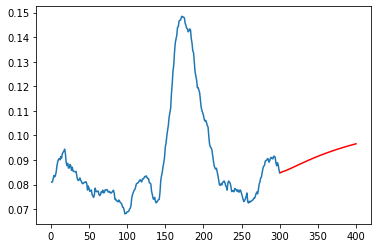

In [229]:
day_new=np.arange(1,301)
day_pred=np.arange(301,401)
plt.plot(day_new, np.array(data[len(data)-300:]).reshape(-1,1))
plt.plot(day_pred, lstm_predict_next_25_days.ravel(), 'r')

#### LSTM with Dropout

In [209]:
two_hun_dropout_lstm_model=keras.models.Sequential([
    keras.layers.LSTM(30, return_sequences=True, input_shape=[200,1]),
    keras.layers.Dropout(0.1),
    keras.layers.LSTM(30),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1)
])

In [210]:
learning_rate_scheduler = keras.optimizers.schedules.ExponentialDecay(0.001,
                                                                      decay_steps=10,
                                                                      decay_rate=0.96,
                                                                      staircase=True)
two_hun_dropout_lstm_model.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(learning_rate=learning_rate_scheduler))
early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
two_hun_dropout_lstm_model_history = two_hun_dropout_lstm_model.fit(x=two_lstm_train_data_X, 
                                                  y=two_lstm_train_data_Y, 
                                                  epochs=10000, 
                                                  validation_data=(two_lstm_validation_data_X, 
                                                                   two_lstm_validation_data_Y),
                                                  callbacks=early_stopping)

Epoch 1/10000
79/79 [==============================] - 10s 132ms/step - loss: 4.8013e-04 - val_loss: 1.5535e-04
Epoch 2/10000
79/79 [==============================] - 11s 139ms/step - loss: 9.6866e-05 - val_loss: 1.2605e-04
Epoch 3/10000
79/79 [==============================] - 11s 133ms/step - loss: 9.1459e-05 - val_loss: 1.2190e-04
Epoch 4/10000
79/79 [==============================] - 11s 138ms/step - loss: 8.2210e-05 - val_loss: 1.2427e-04
Epoch 5/10000
79/79 [==============================] - 11s 143ms/step - loss: 7.4380e-05 - val_loss: 1.1425e-04
Epoch 6/10000
79/79 [==============================] - 12s 149ms/step - loss: 7.5220e-05 - val_loss: 1.1343e-04
Epoch 7/10000
79/79 [==============================] - 14s 176ms/step - loss: 7.0661e-05 - val_loss: 1.1082e-04
Epoch 8/10000
79/79 [==============================] - 12s 146ms/step - loss: 7.0703e-05 - val_loss: 1.0973e-04
Epoch 9/10000
79/79 [==============================] - 11s 138ms/step - loss: 7.1254e-05 - val_loss: 1.0

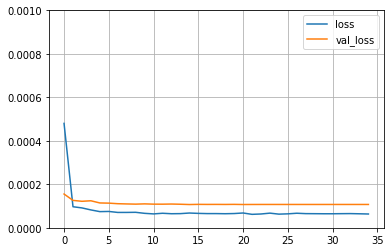

In [211]:
pd.DataFrame(two_hun_dropout_lstm_model_history.history).plot()
plt.grid(True)
plt.gca().set_ylim(0,0.001)
plt.show()

In [215]:
mean_squared_error(two_lstm_test_data_Y.reshape(two_lstm_test_data_Y.shape[0],1), 
                   two_hun_dropout_lstm_model.predict(two_lstm_test_data_X))

1.3034716274578533e-06

In [214]:
mean_squared_error(two_lstm_train_data_Y.reshape(two_lstm_train_data_Y.shape[0],1), 
                   two_hun_dropout_lstm_model.predict(two_lstm_train_data_X))

2.8699438844128463e-05

### 300 steps time interval

In [182]:
three_data=create_volatility_estimate_dataset(usd_inr_data_na_removed, 
                                        time_interval=300, 
                                        volatility_measure='garmin klass volatility')

In [183]:
three_train_data, three_test_data = split_train_test_data(two_data, train_size_percentage=80)

In [184]:
index = int(len(three_train_data)*0.15)
three_train_data=three_train_data[0:len(three_train_data)-index]
three_validation_data=three_train_data[len(three_train_data)-index:]

three_lstm_train_data_X, three_lstm_train_data_Y = prepare_data(three_train_data, 
                                                            time_interval=300)
three_lstm_test_data_X, three_lstm_test_data_Y = prepare_data(three_test_data, 
                                                          time_interval=300)
three_lstm_validation_data_X, three_lstm_validation_data_Y = prepare_data(three_validation_data, 
                                                                      time_interval=300)

In [185]:
print(three_lstm_train_data_X.shape)
print(three_lstm_train_data_Y.shape)

print(three_lstm_test_data_X.shape)
print(three_lstm_test_data_Y.shape)

print(three_lstm_validation_data_X.shape)
print(three_lstm_validation_data_Y.shape)

(2553, 300, 1)
(2553, 1, 1)
(539, 300, 1)
(539, 1, 1)
(202, 300, 1)
(202, 1, 1)


In [187]:
three_hun_lstm_model=keras.models.Sequential([
    keras.layers.LSTM(30, return_sequences=True, input_shape=[300,1]),
    keras.layers.LSTM(30),
    keras.layers.Dense(1)
])

In [189]:
learning_rate_scheduler = keras.optimizers.schedules.ExponentialDecay(0.001,
                                                                      decay_steps=10,
                                                                      decay_rate=0.96,
                                                                      staircase=True)
three_hun_lstm_model.compile(loss="mean_squared_error", 
                           optimizer=keras.optimizers.Adam(learning_rate=learning_rate_scheduler))
early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
three_hun_lstm_model_history = three_hun_lstm_model.fit(x=three_lstm_train_data_X, 
                                                  y=three_lstm_train_data_Y, 
                                                  epochs=10000, 
                                                  validation_data=(three_lstm_validation_data_X, 
                                                                   three_lstm_validation_data_Y),
                                                  callbacks=early_stopping)

Epoch 1/10000
80/80 [==============================] - 15s 190ms/step - loss: 4.5657e-04 - val_loss: 1.5959e-05
Epoch 2/10000
80/80 [==============================] - 15s 184ms/step - loss: 3.6303e-05 - val_loss: 5.5478e-07
Epoch 3/10000
80/80 [==============================] - 15s 189ms/step - loss: 3.1472e-05 - val_loss: 9.8009e-07
Epoch 4/10000
80/80 [==============================] - 15s 183ms/step - loss: 2.9780e-05 - val_loss: 1.6620e-06
Epoch 5/10000
80/80 [==============================] - 14s 179ms/step - loss: 2.9074e-05 - val_loss: 7.4640e-07
Epoch 6/10000
80/80 [==============================] - 14s 179ms/step - loss: 2.7518e-05 - val_loss: 5.0773e-07
Epoch 7/10000
80/80 [==============================] - 14s 178ms/step - loss: 2.7158e-05 - val_loss: 1.1471e-06
Epoch 8/10000
80/80 [==============================] - 14s 179ms/step - loss: 2.6500e-05 - val_loss: 6.3156e-07
Epoch 9/10000
80/80 [==============================] - 15s 183ms/step - loss: 2.6202e-05 - val_loss: 1.3

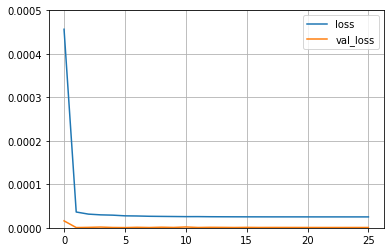

In [193]:
pd.DataFrame(three_hun_lstm_model_history.history).plot()
plt.grid(True)
plt.gca().set_ylim(0,0.0005)
plt.show()

In [194]:
mean_squared_error(three_lstm_test_data_Y.reshape(three_lstm_test_data_Y.shape[0],1), 
                   three_hun_lstm_model.predict(three_lstm_test_data_X))

1.3871537283274088e-06

In [195]:
mean_squared_error(three_lstm_train_data_Y.reshape(three_lstm_train_data_Y.shape[0],1), 
                   three_hun_lstm_model.predict(three_lstm_train_data_X))

2.716781587536795e-05

#### Predict the next 25 values

In [196]:
lstm_predict_next_25_days = predict_n_values(model=three_hun_lstm_model, dataset=data, n_predict=25, time_steps=300, is_nn=True)

4072
1 day input [0.08099127 0.08106744 0.08239633 0.08369375 0.08313056 0.08373465
 0.08528693 0.08775654 0.08938207 0.09017724 0.09058274 0.09006206
 0.09139353 0.09073947 0.0925669  0.09314497 0.09361618 0.09441709
 0.09265128 0.08907738 0.08772872 0.08866184 0.0867085  0.08672789
 0.08815522 0.08767751 0.08580719 0.08706287 0.08552507 0.08531738
 0.08535065 0.08521495 0.0853258  0.08337972 0.08204171 0.08160397
 0.08196494 0.08270346 0.08166231 0.08129853 0.08046962 0.08034098
 0.08073512 0.08077195 0.08105342 0.08112427 0.08031499 0.07778217
 0.07937478 0.07839093 0.07715868 0.07748429 0.07777975 0.07587562
 0.07535527 0.07475002 0.07592065 0.07853158 0.07747561 0.07706233
 0.07718034 0.07733982 0.07593572 0.0754655  0.07595197 0.07707902
 0.07672321 0.07770672 0.07661654 0.07670616 0.07773415 0.07791554
 0.07776348 0.07785447 0.07695712 0.07699648 0.07717605 0.0765818
 0.07652994 0.076889   0.07721348 0.07769224 0.07647484 0.07390454
 0.07399197 0.07335196 0.07322534 0.07293055 0

day output : day_output_size (1, 1),  [[0.08863311]]
4075
4 day input [0.08369375 0.08313056 0.08373465 0.08528693 0.08775654 0.08938207
 0.09017724 0.09058274 0.09006206 0.09139353 0.09073947 0.0925669
 0.09314497 0.09361618 0.09441709 0.09265128 0.08907738 0.08772872
 0.08866184 0.0867085  0.08672789 0.08815522 0.08767751 0.08580719
 0.08706287 0.08552507 0.08531738 0.08535065 0.08521495 0.0853258
 0.08337972 0.08204171 0.08160397 0.08196494 0.08270346 0.08166231
 0.08129853 0.08046962 0.08034098 0.08073512 0.08077195 0.08105342
 0.08112427 0.08031499 0.07778217 0.07937478 0.07839093 0.07715868
 0.07748429 0.07777975 0.07587562 0.07535527 0.07475002 0.07592065
 0.07853158 0.07747561 0.07706233 0.07718034 0.07733982 0.07593572
 0.0754655  0.07595197 0.07707902 0.07672321 0.07770672 0.07661654
 0.07670616 0.07773415 0.07791554 0.07776348 0.07785447 0.07695712
 0.07699648 0.07717605 0.0765818  0.07652994 0.076889   0.07721348
 0.07769224 0.07647484 0.07390454 0.07399197 0.07335196 0.073

day output : day_output_size (1, 1),  [[0.08828522]]
4078
7 day input [0.08528693 0.08775654 0.08938207 0.09017724 0.09058274 0.09006206
 0.09139353 0.09073947 0.0925669  0.09314497 0.09361618 0.09441709
 0.09265128 0.08907738 0.08772872 0.08866184 0.0867085  0.08672789
 0.08815522 0.08767751 0.08580719 0.08706287 0.08552507 0.08531738
 0.08535065 0.08521495 0.0853258  0.08337972 0.08204171 0.08160397
 0.08196494 0.08270346 0.08166231 0.08129853 0.08046962 0.08034098
 0.08073512 0.08077195 0.08105342 0.08112427 0.08031499 0.07778217
 0.07937478 0.07839093 0.07715868 0.07748429 0.07777975 0.07587562
 0.07535527 0.07475002 0.07592065 0.07853158 0.07747561 0.07706233
 0.07718034 0.07733982 0.07593572 0.0754655  0.07595197 0.07707902
 0.07672321 0.07770672 0.07661654 0.07670616 0.07773415 0.07791554
 0.07776348 0.07785447 0.07695712 0.07699648 0.07717605 0.0765818
 0.07652994 0.076889   0.07721348 0.07769224 0.07647484 0.07390454
 0.07399197 0.07335196 0.07322534 0.07293055 0.07369576 0.07

day output : day_output_size (1, 1),  [[0.08803711]]
4082
11 day input [0.09058274 0.09006206 0.09139353 0.09073947 0.0925669  0.09314497
 0.09361618 0.09441709 0.09265128 0.08907738 0.08772872 0.08866184
 0.0867085  0.08672789 0.08815522 0.08767751 0.08580719 0.08706287
 0.08552507 0.08531738 0.08535065 0.08521495 0.0853258  0.08337972
 0.08204171 0.08160397 0.08196494 0.08270346 0.08166231 0.08129853
 0.08046962 0.08034098 0.08073512 0.08077195 0.08105342 0.08112427
 0.08031499 0.07778217 0.07937478 0.07839093 0.07715868 0.07748429
 0.07777975 0.07587562 0.07535527 0.07475002 0.07592065 0.07853158
 0.07747561 0.07706233 0.07718034 0.07733982 0.07593572 0.0754655
 0.07595197 0.07707902 0.07672321 0.07770672 0.07661654 0.07670616
 0.07773415 0.07791554 0.07776348 0.07785447 0.07695712 0.07699648
 0.07717605 0.0765818  0.07652994 0.076889   0.07721348 0.07769224
 0.07647484 0.07390454 0.07399197 0.07335196 0.07322534 0.07293055
 0.07369576 0.07327093 0.0726475  0.07244113 0.07193368 0.0

day output : day_output_size (1, 1),  [[0.08790591]]
4085
14 day input [0.09073947 0.0925669  0.09314497 0.09361618 0.09441709 0.09265128
 0.08907738 0.08772872 0.08866184 0.0867085  0.08672789 0.08815522
 0.08767751 0.08580719 0.08706287 0.08552507 0.08531738 0.08535065
 0.08521495 0.0853258  0.08337972 0.08204171 0.08160397 0.08196494
 0.08270346 0.08166231 0.08129853 0.08046962 0.08034098 0.08073512
 0.08077195 0.08105342 0.08112427 0.08031499 0.07778217 0.07937478
 0.07839093 0.07715868 0.07748429 0.07777975 0.07587562 0.07535527
 0.07475002 0.07592065 0.07853158 0.07747561 0.07706233 0.07718034
 0.07733982 0.07593572 0.0754655  0.07595197 0.07707902 0.07672321
 0.07770672 0.07661654 0.07670616 0.07773415 0.07791554 0.07776348
 0.07785447 0.07695712 0.07699648 0.07717605 0.0765818  0.07652994
 0.076889   0.07721348 0.07769224 0.07647484 0.07390454 0.07399197
 0.07335196 0.07322534 0.07293055 0.07369576 0.07327093 0.0726475
 0.07244113 0.07193368 0.0707848  0.07065389 0.06959366 0.0

day output : day_output_size (1, 1),  [[0.08775144]]
4089
18 day input [0.09441709 0.09265128 0.08907738 0.08772872 0.08866184 0.0867085
 0.08672789 0.08815522 0.08767751 0.08580719 0.08706287 0.08552507
 0.08531738 0.08535065 0.08521495 0.0853258  0.08337972 0.08204171
 0.08160397 0.08196494 0.08270346 0.08166231 0.08129853 0.08046962
 0.08034098 0.08073512 0.08077195 0.08105342 0.08112427 0.08031499
 0.07778217 0.07937478 0.07839093 0.07715868 0.07748429 0.07777975
 0.07587562 0.07535527 0.07475002 0.07592065 0.07853158 0.07747561
 0.07706233 0.07718034 0.07733982 0.07593572 0.0754655  0.07595197
 0.07707902 0.07672321 0.07770672 0.07661654 0.07670616 0.07773415
 0.07791554 0.07776348 0.07785447 0.07695712 0.07699648 0.07717605
 0.0765818  0.07652994 0.076889   0.07721348 0.07769224 0.07647484
 0.07390454 0.07399197 0.07335196 0.07322534 0.07293055 0.07369576
 0.07327093 0.0726475  0.07244113 0.07193368 0.0707848  0.07065389
 0.06959366 0.06803159 0.06822341 0.06830441 0.06889631 0.0

day output : day_output_size (1, 1),  [[0.08760385]]
4093
22 day input [0.08866184 0.0867085  0.08672789 0.08815522 0.08767751 0.08580719
 0.08706287 0.08552507 0.08531738 0.08535065 0.08521495 0.0853258
 0.08337972 0.08204171 0.08160397 0.08196494 0.08270346 0.08166231
 0.08129853 0.08046962 0.08034098 0.08073512 0.08077195 0.08105342
 0.08112427 0.08031499 0.07778217 0.07937478 0.07839093 0.07715868
 0.07748429 0.07777975 0.07587562 0.07535527 0.07475002 0.07592065
 0.07853158 0.07747561 0.07706233 0.07718034 0.07733982 0.07593572
 0.0754655  0.07595197 0.07707902 0.07672321 0.07770672 0.07661654
 0.07670616 0.07773415 0.07791554 0.07776348 0.07785447 0.07695712
 0.07699648 0.07717605 0.0765818  0.07652994 0.076889   0.07721348
 0.07769224 0.07647484 0.07390454 0.07399197 0.07335196 0.07322534
 0.07293055 0.07369576 0.07327093 0.0726475  0.07244113 0.07193368
 0.0707848  0.07065389 0.06959366 0.06803159 0.06822341 0.06830441
 0.06889631 0.0689518  0.0690316  0.06996761 0.07034709 0.0

day output : day_output_size (1, 1),  [[0.08745916]]


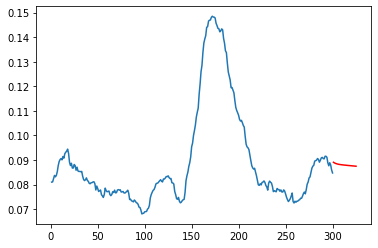

In [197]:
day_new=np.arange(1,301)
day_pred=np.arange(301,326)
plt.plot(day_new, np.array(data[len(data)-300:]).reshape(-1,1))
plt.plot(day_pred, lstm_predict_next_25_days.ravel(), 'r')

### Nadam Optimizer

#### LSTM

In [172]:
two_hun_lstm_model.compile(loss="mean_squared_error", optimizer=keras.optimizers.Nadam())
early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
two_hun_lstm_model_history = two_hun_lstm_model.fit(x=two_lstm_train_data_X, 
                                                  y=two_lstm_train_data_Y, 
                                                  epochs=10000, 
                                                  validation_data=(two_lstm_validation_data_X, 
                                                                   two_lstm_validation_data_Y),
                                                  callbacks=early_stopping)

Epoch 1/10000
79/79 [==============================] - 13s 165ms/step - loss: 6.0483e-05 - val_loss: 2.0021e-04
Epoch 2/10000
79/79 [==============================] - 13s 169ms/step - loss: 4.4534e-05 - val_loss: 8.6106e-05
Epoch 3/10000
79/79 [==============================] - 12s 146ms/step - loss: 3.4852e-05 - val_loss: 7.9582e-05
Epoch 4/10000
79/79 [==============================] - 15s 186ms/step - loss: 4.3590e-05 - val_loss: 7.8765e-05
Epoch 5/10000
79/79 [==============================] - 11s 137ms/step - loss: 2.6745e-05 - val_loss: 1.0696e-04
Epoch 6/10000
79/79 [==============================] - 11s 142ms/step - loss: 3.7264e-05 - val_loss: 6.6810e-05
Epoch 7/10000
79/79 [==============================] - 11s 140ms/step - loss: 2.9482e-05 - val_loss: 6.2534e-05
Epoch 8/10000
79/79 [==============================] - 12s 156ms/step - loss: 2.5002e-05 - val_loss: 5.9078e-05
Epoch 9/10000
79/79 [==============================] - 12s 157ms/step - loss: 2.7285e-05 - val_loss: 5.6

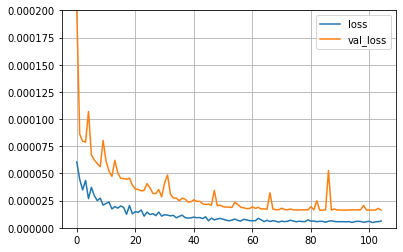

In [174]:
pd.DataFrame(two_hun_lstm_model_history.history).plot()
plt.grid(True)
plt.gca().set_ylim(0,0.0002)
plt.show()

In [175]:
mean_squared_error(two_lstm_test_data_Y.reshape(two_lstm_test_data_Y.shape[0],1), 
                   two_hun_lstm_model.predict(two_lstm_test_data_X))

1.2201131421878736e-07

In [216]:
mean_squared_error(two_lstm_train_data_Y.reshape(two_lstm_train_data_Y.shape[0],1), 
                   two_hun_lstm_model.predict(two_lstm_train_data_X))

4.45052759238478e-06

#### 100 Steps

In [176]:
one_fifty_lstm_model.compile(loss="mean_squared_error", optimizer="nadam")
early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
one_fifty_lstm_model_history = one_fifty_lstm_model.fit(x=one_fifty_lstm_train_data_X, 
                                                  y=one_fifty_lstm_train_data_Y, 
                                                  epochs=10000, 
                                                  validation_data=(one_fifty_lstm_validation_data_X, 
                                                                   one_fifty_lstm_validation_data_Y),
                                                  callbacks=early_stopping)

Epoch 1/10000
72/72 [==============================] - 6s 78ms/step - loss: 6.0203e-05 - val_loss: 1.8106e-04
Epoch 2/10000
72/72 [==============================] - 5s 68ms/step - loss: 4.4099e-05 - val_loss: 9.7638e-05
Epoch 3/10000
72/72 [==============================] - 5s 68ms/step - loss: 4.1548e-05 - val_loss: 1.7354e-04
Epoch 4/10000
72/72 [==============================] - 5s 68ms/step - loss: 3.3697e-05 - val_loss: 1.4577e-04
Epoch 5/10000
72/72 [==============================] - 5s 69ms/step - loss: 3.1351e-05 - val_loss: 7.0016e-05
Epoch 6/10000
72/72 [==============================] - 5s 68ms/step - loss: 2.9714e-05 - val_loss: 1.4290e-04
Epoch 7/10000
72/72 [==============================] - 5s 69ms/step - loss: 3.0553e-05 - val_loss: 1.0476e-04
Epoch 8/10000
72/72 [==============================] - 5s 70ms/step - loss: 2.7199e-05 - val_loss: 5.9307e-05
Epoch 9/10000
72/72 [==============================] - 5s 70ms/step - loss: 2.5932e-05 - val_loss: 6.9907e-05
Epoch 10/1

Epoch 75/10000
72/72 [==============================] - 5s 66ms/step - loss: 7.5212e-06 - val_loss: 1.9659e-05
Epoch 76/10000
72/72 [==============================] - 5s 66ms/step - loss: 5.9188e-06 - val_loss: 1.8773e-05
Epoch 77/10000
72/72 [==============================] - 5s 67ms/step - loss: 6.7218e-06 - val_loss: 2.8916e-05
Epoch 78/10000
72/72 [==============================] - 5s 66ms/step - loss: 8.5543e-06 - val_loss: 1.8762e-05
Epoch 79/10000
72/72 [==============================] - 5s 69ms/step - loss: 6.9944e-06 - val_loss: 1.8664e-05
Epoch 80/10000
72/72 [==============================] - 5s 66ms/step - loss: 6.5995e-06 - val_loss: 1.9541e-05
Epoch 81/10000
72/72 [==============================] - 5s 67ms/step - loss: 6.9262e-06 - val_loss: 1.8682e-05
Epoch 82/10000
72/72 [==============================] - 5s 67ms/step - loss: 7.1014e-06 - val_loss: 1.8661e-05
Epoch 83/10000
72/72 [==============================] - 5s 66ms/step - loss: 6.8054e-06 - val_loss: 1.8647e-05
E

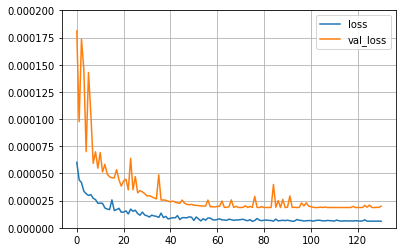

In [177]:
pd.DataFrame(one_fifty_lstm_model_history.history).plot()
plt.grid(True)
plt.gca().set_ylim(0,0.0002)
plt.show()

In [179]:
mean_squared_error(one_fifty_lstm_train_data_Y.reshape(one_fifty_lstm_train_data_Y.shape[0],1), 
                   one_fifty_lstm_model.predict(one_fifty_lstm_train_data_X))

5.192194999735348e-06

#### LSTM with Layer Normalization

In [151]:
layer_normalized_lstm_model_200=keras.models.Sequential([
    keras.layers.LSTM(30, return_sequences=True, input_shape=[200,1]),
    keras.layers.LayerNormalization(),
    keras.layers.LSTM(30),
    keras.layers.LayerNormalization(),
    keras.layers.Dense(1)
])

In [153]:
learning_rate_scheduler = keras.optimizers.schedules.ExponentialDecay(0.001,
                                                                      decay_steps=10,
                                                                      decay_rate=0.96,
                                                                      staircase=True)
layer_normalized_lstm_model_200.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(learning_rate=learning_rate_scheduler))
early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
layer_history = layer_normalized_lstm_model_200.fit(x=two_lstm_train_data_X, 
                                          y=two_lstm_train_data_Y, 
                                          epochs=1000, 
                                          validation_data=(two_lstm_validation_data_X, two_lstm_validation_data_X),
                                          callbacks=early_stopping)

Epoch 1/1000
79/79 [==============================] - 11s 142ms/step - loss: 0.0259 - val_loss: 0.0027
Epoch 2/1000
79/79 [==============================] - 10s 132ms/step - loss: 3.9603e-05 - val_loss: 0.0026
Epoch 3/1000
79/79 [==============================] - 10s 130ms/step - loss: 3.3825e-05 - val_loss: 0.0026
Epoch 4/1000
79/79 [==============================] - 10s 132ms/step - loss: 3.2329e-05 - val_loss: 0.0025
Epoch 5/1000
79/79 [==============================] - 10s 133ms/step - loss: 3.1329e-05 - val_loss: 0.0025
Epoch 6/1000
79/79 [==============================] - 10s 133ms/step - loss: 2.9757e-05 - val_loss: 0.0025
Epoch 7/1000
79/79 [==============================] - 10s 132ms/step - loss: 2.9002e-05 - val_loss: 0.0025
Epoch 8/1000
79/79 [==============================] - 10s 132ms/step - loss: 2.8228e-05 - val_loss: 0.0025
Epoch 9/1000
79/79 [==============================] - 10s 133ms/step - loss: 2.7788e-05 - val_loss: 0.0025
Epoch 10/1000
79/79 [====================

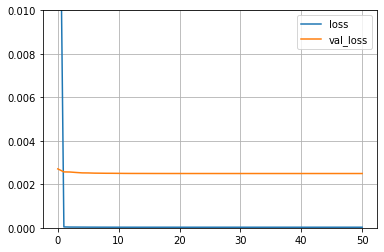

In [155]:
pd.DataFrame(layer_history.history).plot()
plt.grid(True)
plt.gca().set_ylim(0,0.01)
plt.show()

In [156]:
mean_squared_error(two_lstm_test_data_Y.reshape(two_lstm_test_data_Y.shape[0],1), 
                   layer_normalized_lstm_model_200.predict(two_lstm_test_data_X))

3.2251611457289003e-06

In [207]:
mean_squared_error(two_lstm_train_data_Y.reshape(two_lstm_train_data_Y.shape[0],1), 
                   layer_normalized_lstm_model_200.predict(two_lstm_train_data_X))

2.61981234708876e-05

#### LSTM with Dropout

In [237]:
dropout_lstm_model_200=keras.models.Sequential([
    keras.layers.LSTM(30, return_sequences=True, input_shape=[200,1]),
    keras.layers.Dropout(0.1),
    keras.layers.LSTM(30),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1)
])

In [238]:
learning_rate_scheduler = keras.optimizers.schedules.ExponentialDecay(0.001,
                                                                      decay_steps=10,
                                                                      decay_rate=0.96,
                                                                      staircase=True)
dropout_lstm_model_200.compile(loss="mean_squared_error", optimizer=keras.optimizers.Adam(learning_rate=learning_rate_scheduler))
early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
dropout_history = dropout_lstm_model_200.fit(x=two_lstm_train_data_X, 
                                          y=two_lstm_train_data_Y, 
                                          epochs=1000, 
                                          validation_data=(two_lstm_validation_data_X, two_lstm_validation_data_X),
                                          callbacks=early_stopping)

Epoch 1/1000
79/79 [==============================] - 23s 292ms/step - loss: 5.1105e-04 - val_loss: 0.0019
Epoch 2/1000
79/79 [==============================] - 10s 129ms/step - loss: 8.5644e-05 - val_loss: 0.0022
Epoch 3/1000
79/79 [==============================] - 16s 201ms/step - loss: 8.8656e-05 - val_loss: 0.0022
Epoch 4/1000
79/79 [==============================] - 12s 157ms/step - loss: 7.4694e-05 - val_loss: 0.0022
Epoch 5/1000
79/79 [==============================] - 12s 150ms/step - loss: 7.8307e-05 - val_loss: 0.0022
Epoch 6/1000
79/79 [==============================] - 17s 221ms/step - loss: 6.9823e-05 - val_loss: 0.0022
Epoch 7/1000
79/79 [==============================] - 12s 153ms/step - loss: 7.4301e-05 - val_loss: 0.0022
Epoch 8/1000
79/79 [==============================] - 13s 161ms/step - loss: 6.8055e-05 - val_loss: 0.0022
Epoch 9/1000
79/79 [==============================] - 13s 163ms/step - loss: 6.9448e-05 - val_loss: 0.0022
Epoch 10/1000
79/79 [================

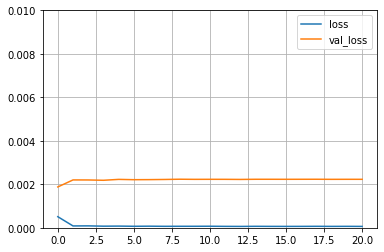

In [241]:
pd.DataFrame(dropout_history.history).plot()
plt.grid(True)
plt.gca().set_ylim(0,0.01)
plt.show()

In [242]:
mean_squared_error(two_lstm_test_data_Y.reshape(two_lstm_test_data_Y.shape[0],1), 
                   dropout_lstm_model_200.predict(two_lstm_test_data_X))

1.7330873258388976e-05

In [243]:
mean_squared_error(two_lstm_train_data_Y.reshape(two_lstm_train_data_Y.shape[0],1), 
                   dropout_lstm_model_200.predict(two_lstm_train_data_X))

5.68199258956085e-05